# Integration of CITE-seq and scRNA-seq data

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.

Uncomment the following lines in Google Colab in order to install `scvi-tools`:

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install

# install()

In [2]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi
import torch
from scipy.stats import pearsonr

## Imports and data loading

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


You can modify `save_dir` below to change where the data files for this tutorial are saved.

In [4]:
sc.set_figure_params(figsize=(4, 4))
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [5]:
adata = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir.name)

INFO     Downloading file at /tmp/tmplm0peela/pbmc_10k_protein_v3.h5ad                                             


Downloading...:   0%|          | 0/24937.0 [00:00<?, ?it/s]

Downloading...:  26%|██▌       | 6363/24937.0 [00:00<00:00, 63498.20it/s]

Downloading...:  65%|██████▌   | 16255/24937.0 [00:00<00:00, 84295.90it/s]

Downloading...:  99%|█████████▉| 24687/24937.0 [00:00<00:00, 83905.35it/s]

Downloading...: 24938it [00:00, 82056.93it/s]                             

INFO     Downloading file at /tmp/tmplm0peela/pbmc_5k_protein_v3.h5ad                                              


Downloading...:   0%|          | 0/18295.0 [00:00<?, ?it/s]

Downloading...:  34%|███▍      | 6231/18295.0 [00:00<00:00, 61780.09it/s]

Downloading...:  90%|████████▉ | 16447/18295.0 [00:00<00:00, 85392.15it/s]

Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 83116.56it/s]

/env/lib/python3.11/site-packages/scvi/data/_built_in_data/_cite_seq.py:47: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.


/env/lib/python3.11/site-packages/scvi/data/_built_in_data/_cite_seq.py:52: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [6]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1    PBMC10k
AAACCCACATCGGTTA-1    PBMC10k
AAACCCAGTACCGCGT-1    PBMC10k
AAACCCAGTATCGAAA-1    PBMC10k
AAACCCAGTCGTCATA-1    PBMC10k
                       ...   
TTTGGTTGTACGAGTG-1     PBMC5k
TTTGTTGAGTTAACAG-1     PBMC5k
TTTGTTGCAGCACAAG-1     PBMC5k
TTTGTTGCAGTCTTCC-1     PBMC5k
TTTGTTGCATTGCCGG-1     PBMC5k
Name: batch, Length: 10849, dtype: object

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [7]:
held_out_proteins = adata.obsm["protein_expression"][batch == "PBMC5k"].copy()
adata.obsm["protein_expression"].loc[batch == "PBMC5k"] = np.zeros_like(
    adata.obsm["protein_expression"][batch == "PBMC5k"]
)

In [8]:
sc.pp.highly_variable_genes(
    adata, batch_key="batch", flavor="seurat_v3", n_top_genes=4000, subset=True
)

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


```{important}
scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.
```

In [9]:
scvi.model.TOTALVI.setup_anndata(
    adata, batch_key="batch", protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                                       


INFO     Found batches with missing protein expression                                                             


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



## Prepare and run model

In [10]:
model = scvi.model.TOTALVI(adata, latent_distribution="normal", n_layers_decoder=2)

INFO     Computing empirical prior initialization for protein background.                                          


/tmp/ipykernel_158/3261033344.py:1: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.


In [11]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:01<07:17,  1.10s/it]

Epoch 1/400:   0%|          | 1/400 [00:01<07:17,  1.10s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.96e+3]

Epoch 2/400:   0%|          | 1/400 [00:01<07:17,  1.10s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.96e+3]

Epoch 2/400:   0%|          | 2/400 [00:01<05:07,  1.29it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.96e+3]

Epoch 2/400:   0%|          | 2/400 [00:01<05:07,  1.29it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.35e+3]

Epoch 3/400:   0%|          | 2/400 [00:01<05:07,  1.29it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.35e+3]

Epoch 3/400:   1%|          | 3/400 [00:02<04:25,  1.50it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.35e+3]

Epoch 3/400:   1%|          | 3/400 [00:02<04:25,  1.50it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.33e+3]

Epoch 4/400:   1%|          | 3/400 [00:02<04:25,  1.50it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.33e+3]

Epoch 4/400:   1%|          | 4/400 [00:02<04:05,  1.61it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.33e+3]

Epoch 4/400:   1%|          | 4/400 [00:02<04:05,  1.61it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.31e+3]

Epoch 5/400:   1%|          | 4/400 [00:02<04:05,  1.61it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.31e+3]

Epoch 5/400:   1%|▏         | 5/400 [00:03<03:54,  1.69it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.31e+3]

Epoch 5/400:   1%|▏         | 5/400 [00:03<03:54,  1.69it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.3e+3] 

Epoch 6/400:   1%|▏         | 5/400 [00:03<03:54,  1.69it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.3e+3]

Epoch 6/400:   2%|▏         | 6/400 [00:03<03:47,  1.73it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.3e+3]

Epoch 6/400:   2%|▏         | 6/400 [00:03<03:47,  1.73it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.29e+3]

Epoch 7/400:   2%|▏         | 6/400 [00:03<03:47,  1.73it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.29e+3]

Epoch 7/400:   2%|▏         | 7/400 [00:04<03:42,  1.76it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.29e+3]

Epoch 7/400:   2%|▏         | 7/400 [00:04<03:42,  1.76it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.29e+3]

Epoch 8/400:   2%|▏         | 7/400 [00:04<03:42,  1.76it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.29e+3]

Epoch 8/400:   2%|▏         | 8/400 [00:04<03:39,  1.79it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.29e+3]

Epoch 8/400:   2%|▏         | 8/400 [00:04<03:39,  1.79it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.28e+3]

Epoch 9/400:   2%|▏         | 8/400 [00:04<03:39,  1.79it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.28e+3]

Epoch 9/400:   2%|▏         | 9/400 [00:05<03:37,  1.80it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.28e+3]

Epoch 9/400:   2%|▏         | 9/400 [00:05<03:37,  1.80it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.28e+3]

Epoch 10/400:   2%|▏         | 9/400 [00:05<03:37,  1.80it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.28e+3]

Epoch 10/400:   2%|▎         | 10/400 [00:06<03:35,  1.81it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.28e+3]

Epoch 10/400:   2%|▎         | 10/400 [00:06<03:35,  1.81it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.27e+3] 

Epoch 11/400:   2%|▎         | 10/400 [00:06<03:35,  1.81it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.27e+3]

Epoch 11/400:   3%|▎         | 11/400 [00:06<03:34,  1.82it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.27e+3]

Epoch 11/400:   3%|▎         | 11/400 [00:06<03:34,  1.82it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.27e+3]

Epoch 12/400:   3%|▎         | 11/400 [00:06<03:34,  1.82it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.27e+3]

Epoch 12/400:   3%|▎         | 12/400 [00:07<03:33,  1.82it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.27e+3]

Epoch 12/400:   3%|▎         | 12/400 [00:07<03:33,  1.82it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.26e+3]

Epoch 13/400:   3%|▎         | 12/400 [00:07<03:33,  1.82it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.26e+3]

Epoch 13/400:   3%|▎         | 13/400 [00:07<03:32,  1.82it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.26e+3]

Epoch 13/400:   3%|▎         | 13/400 [00:07<03:32,  1.82it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.26e+3]

Epoch 14/400:   3%|▎         | 13/400 [00:07<03:32,  1.82it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.26e+3]

Epoch 14/400:   4%|▎         | 14/400 [00:08<03:31,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.26e+3]

Epoch 14/400:   4%|▎         | 14/400 [00:08<03:31,  1.83it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.26e+3]

Epoch 15/400:   4%|▎         | 14/400 [00:08<03:31,  1.83it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.26e+3]

Epoch 15/400:   4%|▍         | 15/400 [00:08<03:30,  1.83it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.26e+3]

Epoch 15/400:   4%|▍         | 15/400 [00:08<03:30,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.25e+3]

Epoch 16/400:   4%|▍         | 15/400 [00:08<03:30,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.25e+3]

Epoch 16/400:   4%|▍         | 16/400 [00:09<03:29,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.25e+3]

Epoch 16/400:   4%|▍         | 16/400 [00:09<03:29,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.25e+3]

Epoch 17/400:   4%|▍         | 16/400 [00:09<03:29,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.25e+3]

Epoch 17/400:   4%|▍         | 17/400 [00:09<03:29,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.25e+3]

Epoch 17/400:   4%|▍         | 17/400 [00:09<03:29,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.25e+3]

Epoch 18/400:   4%|▍         | 17/400 [00:09<03:29,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.25e+3]

Epoch 18/400:   4%|▍         | 18/400 [00:10<03:28,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.25e+3]

Epoch 18/400:   4%|▍         | 18/400 [00:10<03:28,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.25e+3]

Epoch 19/400:   4%|▍         | 18/400 [00:10<03:28,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.25e+3]

Epoch 19/400:   5%|▍         | 19/400 [00:10<03:28,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.25e+3]

Epoch 19/400:   5%|▍         | 19/400 [00:10<03:28,  1.83it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.24e+3]

Epoch 20/400:   5%|▍         | 19/400 [00:10<03:28,  1.83it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.24e+3]

Epoch 20/400:   5%|▌         | 20/400 [00:11<03:27,  1.83it/s, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.24e+3]

Epoch 20/400:   5%|▌         | 20/400 [00:11<03:27,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.24e+3]

Epoch 21/400:   5%|▌         | 20/400 [00:11<03:27,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.24e+3]

Epoch 21/400:   5%|▌         | 21/400 [00:12<03:26,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.24e+3]

Epoch 21/400:   5%|▌         | 21/400 [00:12<03:26,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.24e+3] 

Epoch 22/400:   5%|▌         | 21/400 [00:12<03:26,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.24e+3]

Epoch 22/400:   6%|▌         | 22/400 [00:12<03:26,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.24e+3]

Epoch 22/400:   6%|▌         | 22/400 [00:12<03:26,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.24e+3]

Epoch 23/400:   6%|▌         | 22/400 [00:12<03:26,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.24e+3]

Epoch 23/400:   6%|▌         | 23/400 [00:13<03:25,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.24e+3]

Epoch 23/400:   6%|▌         | 23/400 [00:13<03:25,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.24e+3]

Epoch 24/400:   6%|▌         | 23/400 [00:13<03:25,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.24e+3]

Epoch 24/400:   6%|▌         | 24/400 [00:13<03:25,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.24e+3]

Epoch 24/400:   6%|▌         | 24/400 [00:13<03:25,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.23e+3]

Epoch 25/400:   6%|▌         | 24/400 [00:13<03:25,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.23e+3]

Epoch 25/400:   6%|▋         | 25/400 [00:14<03:24,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.23e+3]

Epoch 25/400:   6%|▋         | 25/400 [00:14<03:24,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.23e+3]

Epoch 26/400:   6%|▋         | 25/400 [00:14<03:24,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.23e+3]

Epoch 26/400:   6%|▋         | 26/400 [00:14<03:24,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.23e+3]

Epoch 26/400:   6%|▋         | 26/400 [00:14<03:24,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.23e+3]

Epoch 27/400:   6%|▋         | 26/400 [00:14<03:24,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.23e+3]

Epoch 27/400:   7%|▋         | 27/400 [00:15<03:23,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.23e+3]

Epoch 27/400:   7%|▋         | 27/400 [00:15<03:23,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.23e+3]

Epoch 28/400:   7%|▋         | 27/400 [00:15<03:23,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.23e+3]

Epoch 28/400:   7%|▋         | 28/400 [00:15<03:23,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.23e+3]

Epoch 28/400:   7%|▋         | 28/400 [00:15<03:23,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.23e+3]

Epoch 29/400:   7%|▋         | 28/400 [00:15<03:23,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.23e+3]

Epoch 29/400:   7%|▋         | 29/400 [00:16<03:22,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.23e+3]

Epoch 29/400:   7%|▋         | 29/400 [00:16<03:22,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.23e+3]

Epoch 30/400:   7%|▋         | 29/400 [00:16<03:22,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.23e+3]

Epoch 30/400:   8%|▊         | 30/400 [00:16<03:22,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.23e+3]

Epoch 30/400:   8%|▊         | 30/400 [00:16<03:22,  1.83it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.23e+3]

Epoch 31/400:   8%|▊         | 30/400 [00:16<03:22,  1.83it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.23e+3]

Epoch 31/400:   8%|▊         | 31/400 [00:17<03:21,  1.83it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.23e+3]

Epoch 31/400:   8%|▊         | 31/400 [00:17<03:21,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.23e+3]

Epoch 32/400:   8%|▊         | 31/400 [00:17<03:21,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.23e+3]

Epoch 32/400:   8%|▊         | 32/400 [00:18<03:20,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.23e+3]

Epoch 32/400:   8%|▊         | 32/400 [00:18<03:20,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.23e+3]

Epoch 33/400:   8%|▊         | 32/400 [00:18<03:20,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.23e+3]

Epoch 33/400:   8%|▊         | 33/400 [00:18<03:20,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.23e+3]

Epoch 33/400:   8%|▊         | 33/400 [00:18<03:20,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.23e+3]

Epoch 34/400:   8%|▊         | 33/400 [00:18<03:20,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.23e+3]

Epoch 34/400:   8%|▊         | 34/400 [00:19<03:20,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.23e+3]

Epoch 34/400:   8%|▊         | 34/400 [00:19<03:20,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.23e+3]

Epoch 35/400:   8%|▊         | 34/400 [00:19<03:20,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.23e+3]

Epoch 35/400:   9%|▉         | 35/400 [00:19<03:19,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.23e+3]

Epoch 35/400:   9%|▉         | 35/400 [00:19<03:19,  1.83it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.22e+3]

Epoch 36/400:   9%|▉         | 35/400 [00:19<03:19,  1.83it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.22e+3]

Epoch 36/400:   9%|▉         | 36/400 [00:20<03:18,  1.83it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.22e+3]

Epoch 36/400:   9%|▉         | 36/400 [00:20<03:18,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.22e+3]

Epoch 37/400:   9%|▉         | 36/400 [00:20<03:18,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.22e+3]

Epoch 37/400:   9%|▉         | 37/400 [00:20<03:18,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.22e+3]

Epoch 37/400:   9%|▉         | 37/400 [00:20<03:18,  1.83it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.22e+3]

Epoch 38/400:   9%|▉         | 37/400 [00:20<03:18,  1.83it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.22e+3]

Epoch 38/400:  10%|▉         | 38/400 [00:21<03:17,  1.83it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.22e+3]

Epoch 38/400:  10%|▉         | 38/400 [00:21<03:17,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.22e+3] 

Epoch 39/400:  10%|▉         | 38/400 [00:21<03:17,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.22e+3]

Epoch 39/400:  10%|▉         | 39/400 [00:21<03:17,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.22e+3]

Epoch 39/400:  10%|▉         | 39/400 [00:21<03:17,  1.83it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.22e+3]

Epoch 40/400:  10%|▉         | 39/400 [00:21<03:17,  1.83it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.22e+3]

Epoch 40/400:  10%|█         | 40/400 [00:22<03:16,  1.83it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.22e+3]

Epoch 40/400:  10%|█         | 40/400 [00:22<03:16,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 41/400:  10%|█         | 40/400 [00:22<03:16,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 41/400:  10%|█         | 41/400 [00:22<03:16,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 41/400:  10%|█         | 41/400 [00:22<03:16,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.22e+3]

Epoch 42/400:  10%|█         | 41/400 [00:22<03:16,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.22e+3]

Epoch 42/400:  10%|█         | 42/400 [00:23<03:15,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.22e+3]

Epoch 42/400:  10%|█         | 42/400 [00:23<03:15,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 43/400:  10%|█         | 42/400 [00:23<03:15,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 43/400:  11%|█         | 43/400 [00:24<03:15,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 43/400:  11%|█         | 43/400 [00:24<03:15,  1.83it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.22e+3] 

Epoch 44/400:  11%|█         | 43/400 [00:24<03:15,  1.83it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.22e+3]

Epoch 44/400:  11%|█         | 44/400 [00:24<03:14,  1.83it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.22e+3]

Epoch 44/400:  11%|█         | 44/400 [00:24<03:14,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 45/400:  11%|█         | 44/400 [00:24<03:14,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 45/400:  11%|█▏        | 45/400 [00:25<03:13,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 45/400:  11%|█▏        | 45/400 [00:25<03:13,  1.83it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.22e+3]

Epoch 46/400:  11%|█▏        | 45/400 [00:25<03:13,  1.83it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.22e+3]

Epoch 46/400:  12%|█▏        | 46/400 [00:25<03:13,  1.83it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.22e+3]

Epoch 46/400:  12%|█▏        | 46/400 [00:25<03:13,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.22e+3]

Epoch 47/400:  12%|█▏        | 46/400 [00:25<03:13,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.22e+3]

Epoch 47/400:  12%|█▏        | 47/400 [00:26<03:12,  1.83it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.22e+3]

Epoch 47/400:  12%|█▏        | 47/400 [00:26<03:12,  1.83it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.22e+3]

Epoch 48/400:  12%|█▏        | 47/400 [00:26<03:12,  1.83it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.22e+3]

Epoch 48/400:  12%|█▏        | 48/400 [00:26<03:12,  1.83it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.22e+3]

Epoch 48/400:  12%|█▏        | 48/400 [00:26<03:12,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.22e+3]

Epoch 49/400:  12%|█▏        | 48/400 [00:26<03:12,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.22e+3]

Epoch 49/400:  12%|█▏        | 49/400 [00:27<03:11,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.22e+3]

Epoch 49/400:  12%|█▏        | 49/400 [00:27<03:11,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.22e+3]

Epoch 50/400:  12%|█▏        | 49/400 [00:27<03:11,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.22e+3]

Epoch 50/400:  12%|█▎        | 50/400 [00:27<03:11,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.22e+3]

Epoch 50/400:  12%|█▎        | 50/400 [00:27<03:11,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 51/400:  12%|█▎        | 50/400 [00:27<03:11,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 51/400:  13%|█▎        | 51/400 [00:28<03:10,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 51/400:  13%|█▎        | 51/400 [00:28<03:10,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.22e+3]

Epoch 52/400:  13%|█▎        | 51/400 [00:28<03:10,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.22e+3]

Epoch 52/400:  13%|█▎        | 52/400 [00:28<03:10,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.22e+3]

Epoch 52/400:  13%|█▎        | 52/400 [00:28<03:10,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 53/400:  13%|█▎        | 52/400 [00:28<03:10,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 53/400:  13%|█▎        | 53/400 [00:29<03:09,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 53/400:  13%|█▎        | 53/400 [00:29<03:09,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.22e+3]

Epoch 54/400:  13%|█▎        | 53/400 [00:29<03:09,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.22e+3]

Epoch 54/400:  14%|█▎        | 54/400 [00:30<03:08,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.22e+3]

Epoch 54/400:  14%|█▎        | 54/400 [00:30<03:08,  1.83it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.22e+3]

Epoch 55/400:  14%|█▎        | 54/400 [00:30<03:08,  1.83it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.22e+3]

Epoch 55/400:  14%|█▍        | 55/400 [00:30<03:08,  1.83it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.22e+3]

Epoch 55/400:  14%|█▍        | 55/400 [00:30<03:08,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 56/400:  14%|█▍        | 55/400 [00:30<03:08,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 56/400:  14%|█▍        | 56/400 [00:31<03:07,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 56/400:  14%|█▍        | 56/400 [00:31<03:07,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 57/400:  14%|█▍        | 56/400 [00:31<03:07,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 57/400:  14%|█▍        | 57/400 [00:31<03:07,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 57/400:  14%|█▍        | 57/400 [00:31<03:07,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 58/400:  14%|█▍        | 57/400 [00:31<03:07,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 58/400:  14%|█▍        | 58/400 [00:32<03:06,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 58/400:  14%|█▍        | 58/400 [00:32<03:06,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 59/400:  14%|█▍        | 58/400 [00:32<03:06,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 59/400:  15%|█▍        | 59/400 [00:32<03:06,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 59/400:  15%|█▍        | 59/400 [00:32<03:06,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.22e+3]

Epoch 60/400:  15%|█▍        | 59/400 [00:32<03:06,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.22e+3]

Epoch 60/400:  15%|█▌        | 60/400 [00:33<03:05,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.22e+3]

Epoch 60/400:  15%|█▌        | 60/400 [00:33<03:05,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.22e+3]

Epoch 61/400:  15%|█▌        | 60/400 [00:33<03:05,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.22e+3]

Epoch 61/400:  15%|█▌        | 61/400 [00:33<03:05,  1.83it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.22e+3]

Epoch 61/400:  15%|█▌        | 61/400 [00:33<03:05,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 62/400:  15%|█▌        | 61/400 [00:33<03:05,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 62/400:  16%|█▌        | 62/400 [00:34<03:04,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 62/400:  16%|█▌        | 62/400 [00:34<03:04,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 63/400:  16%|█▌        | 62/400 [00:34<03:04,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 63/400:  16%|█▌        | 63/400 [00:34<03:04,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 63/400:  16%|█▌        | 63/400 [00:34<03:04,  1.83it/s, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.22e+3]

Epoch 64/400:  16%|█▌        | 63/400 [00:34<03:04,  1.83it/s, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.22e+3]

Epoch 64/400:  16%|█▌        | 64/400 [00:35<03:03,  1.83it/s, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.22e+3]

Epoch 64/400:  16%|█▌        | 64/400 [00:35<03:03,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 65/400:  16%|█▌        | 64/400 [00:35<03:03,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 65/400:  16%|█▋        | 65/400 [00:36<03:03,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 65/400:  16%|█▋        | 65/400 [00:36<03:03,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 66/400:  16%|█▋        | 65/400 [00:36<03:03,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 66/400:  16%|█▋        | 66/400 [00:36<03:02,  1.83it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.22e+3]

Epoch 66/400:  16%|█▋        | 66/400 [00:36<03:02,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.22e+3]

Epoch 67/400:  16%|█▋        | 66/400 [00:36<03:02,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.22e+3]

Epoch 67/400:  17%|█▋        | 67/400 [00:37<03:01,  1.83it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.22e+3]

Epoch 67/400:  17%|█▋        | 67/400 [00:37<03:01,  1.83it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.22e+3]

Epoch 68/400:  17%|█▋        | 67/400 [00:37<03:01,  1.83it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.22e+3]

Epoch 68/400:  17%|█▋        | 68/400 [00:37<03:01,  1.83it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.22e+3]

Epoch 68/400:  17%|█▋        | 68/400 [00:37<03:01,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 69/400:  17%|█▋        | 68/400 [00:37<03:01,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 69/400:  17%|█▋        | 69/400 [00:38<03:00,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 69/400:  17%|█▋        | 69/400 [00:38<03:00,  1.83it/s, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.22e+3]

Epoch 70/400:  17%|█▋        | 69/400 [00:38<03:00,  1.83it/s, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.22e+3]

Epoch 70/400:  18%|█▊        | 70/400 [00:38<03:00,  1.83it/s, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.22e+3]

Epoch 70/400:  18%|█▊        | 70/400 [00:38<03:00,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 71/400:  18%|█▊        | 70/400 [00:38<03:00,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 71/400:  18%|█▊        | 71/400 [00:39<02:59,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 71/400:  18%|█▊        | 71/400 [00:39<02:59,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.22e+3] 

Epoch 72/400:  18%|█▊        | 71/400 [00:39<02:59,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.22e+3]

Epoch 72/400:  18%|█▊        | 72/400 [00:39<02:59,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.22e+3]

Epoch 72/400:  18%|█▊        | 72/400 [00:39<02:59,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.22e+3]

Epoch 73/400:  18%|█▊        | 72/400 [00:39<02:59,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.22e+3]

Epoch 73/400:  18%|█▊        | 73/400 [00:40<02:58,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.22e+3]

Epoch 73/400:  18%|█▊        | 73/400 [00:40<02:58,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 74/400:  18%|█▊        | 73/400 [00:40<02:58,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 74/400:  18%|█▊        | 74/400 [00:40<02:57,  1.83it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

Epoch 74/400:  18%|█▊        | 74/400 [00:40<02:57,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 75/400:  18%|█▊        | 74/400 [00:40<02:57,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 75/400:  19%|█▉        | 75/400 [00:41<02:57,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 75/400:  19%|█▉        | 75/400 [00:41<02:57,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 76/400:  19%|█▉        | 75/400 [00:41<02:57,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 76/400:  19%|█▉        | 76/400 [00:42<02:57,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 76/400:  19%|█▉        | 76/400 [00:42<02:57,  1.83it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.22e+3] 

Epoch 77/400:  19%|█▉        | 76/400 [00:42<02:57,  1.83it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.22e+3]

Epoch 77/400:  19%|█▉        | 77/400 [00:42<02:56,  1.83it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.22e+3]

Epoch 77/400:  19%|█▉        | 77/400 [00:42<02:56,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 78/400:  19%|█▉        | 77/400 [00:42<02:56,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 78/400:  20%|█▉        | 78/400 [00:43<02:56,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.22e+3]

Epoch 78/400:  20%|█▉        | 78/400 [00:43<02:56,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.22e+3]

Epoch 79/400:  20%|█▉        | 78/400 [00:43<02:56,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.22e+3]

Epoch 79/400:  20%|█▉        | 79/400 [00:43<02:55,  1.83it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.22e+3]

Epoch 79/400:  20%|█▉        | 79/400 [00:43<02:55,  1.83it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.22e+3]

Epoch 80/400:  20%|█▉        | 79/400 [00:43<02:55,  1.83it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.22e+3]

Epoch 80/400:  20%|██        | 80/400 [00:44<02:54,  1.83it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.22e+3]

Epoch 80/400:  20%|██        | 80/400 [00:44<02:54,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.22e+3] 

Epoch 81/400:  20%|██        | 80/400 [00:44<02:54,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.22e+3]

Epoch 81/400:  20%|██        | 81/400 [00:44<02:54,  1.83it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.22e+3]

Epoch 81/400:  20%|██        | 81/400 [00:44<02:54,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 82/400:  20%|██        | 81/400 [00:44<02:54,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 82/400:  20%|██        | 82/400 [00:45<02:53,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 82/400:  20%|██        | 82/400 [00:45<02:53,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 83/400:  20%|██        | 82/400 [00:45<02:53,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 83/400:  21%|██        | 83/400 [00:45<02:53,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.22e+3]

Epoch 83/400:  21%|██        | 83/400 [00:45<02:53,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 84/400:  21%|██        | 83/400 [00:45<02:53,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 84/400:  21%|██        | 84/400 [00:46<02:52,  1.83it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 84/400:  21%|██        | 84/400 [00:46<02:52,  1.83it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.22e+3] 

Epoch 85/400:  21%|██        | 84/400 [00:46<02:52,  1.83it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.22e+3]

Epoch 85/400:  21%|██▏       | 85/400 [00:46<02:52,  1.83it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.22e+3]

Epoch 85/400:  21%|██▏       | 85/400 [00:46<02:52,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 86/400:  21%|██▏       | 85/400 [00:46<02:52,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 86/400:  22%|██▏       | 86/400 [00:47<02:51,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 86/400:  22%|██▏       | 86/400 [00:47<02:51,  1.83it/s, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.21e+3]

Epoch 87/400:  22%|██▏       | 86/400 [00:47<02:51,  1.83it/s, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.21e+3]

Epoch 87/400:  22%|██▏       | 87/400 [00:48<02:51,  1.83it/s, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.21e+3]

Epoch 87/400:  22%|██▏       | 87/400 [00:48<02:51,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 88/400:  22%|██▏       | 87/400 [00:48<02:51,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 88/400:  22%|██▏       | 88/400 [00:48<02:50,  1.83it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 88/400:  22%|██▏       | 88/400 [00:48<02:50,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 89/400:  22%|██▏       | 88/400 [00:48<02:50,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 89/400:  22%|██▏       | 89/400 [00:49<02:49,  1.83it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.22e+3]

Epoch 89/400:  22%|██▏       | 89/400 [00:49<02:49,  1.83it/s, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.22e+3]

Epoch 90/400:  22%|██▏       | 89/400 [00:49<02:49,  1.83it/s, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.22e+3]

Epoch 90/400:  22%|██▎       | 90/400 [00:49<02:49,  1.83it/s, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.22e+3]

Epoch 90/400:  22%|██▎       | 90/400 [00:49<02:49,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.22e+3]

Epoch 91/400:  22%|██▎       | 90/400 [00:49<02:49,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.22e+3]

Epoch 91/400:  23%|██▎       | 91/400 [00:50<02:48,  1.83it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.22e+3]

Epoch 91/400:  23%|██▎       | 91/400 [00:50<02:48,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 92/400:  23%|██▎       | 91/400 [00:50<02:48,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 92/400:  23%|██▎       | 92/400 [00:50<02:48,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 92/400:  23%|██▎       | 92/400 [00:50<02:48,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.21e+3]

Epoch 93/400:  23%|██▎       | 92/400 [00:50<02:48,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.21e+3]

Epoch 93/400:  23%|██▎       | 93/400 [00:51<02:47,  1.83it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.21e+3]

Epoch 93/400:  23%|██▎       | 93/400 [00:51<02:47,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.22e+3]

Epoch 94/400:  23%|██▎       | 93/400 [00:51<02:47,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.22e+3]

Epoch 94/400:  24%|██▎       | 94/400 [00:51<02:47,  1.83it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.22e+3]

Epoch 94/400:  24%|██▎       | 94/400 [00:51<02:47,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.22e+3] 

Epoch 95/400:  24%|██▎       | 94/400 [00:51<02:47,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.22e+3]

Epoch 95/400:  24%|██▍       | 95/400 [00:52<02:46,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.22e+3]

Epoch 95/400:  24%|██▍       | 95/400 [00:52<02:46,  1.83it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.21e+3]

Epoch 96/400:  24%|██▍       | 95/400 [00:52<02:46,  1.83it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.21e+3]

Epoch 96/400:  24%|██▍       | 96/400 [00:52<02:46,  1.83it/s, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=1.21e+3]

Epoch 96/400:  24%|██▍       | 96/400 [00:52<02:46,  1.83it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 97/400:  24%|██▍       | 96/400 [00:52<02:46,  1.83it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 97/400:  24%|██▍       | 97/400 [00:53<02:45,  1.83it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 97/400:  24%|██▍       | 97/400 [00:53<02:45,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 98/400:  24%|██▍       | 97/400 [00:53<02:45,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 98/400:  24%|██▍       | 98/400 [00:54<02:45,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 98/400:  24%|██▍       | 98/400 [00:54<02:45,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3] 

Epoch 99/400:  24%|██▍       | 98/400 [00:54<02:45,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3]

Epoch 99/400:  25%|██▍       | 99/400 [00:54<02:44,  1.83it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3]

Epoch 99/400:  25%|██▍       | 99/400 [00:54<02:44,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.22e+3]

Epoch 100/400:  25%|██▍       | 99/400 [00:54<02:44,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.22e+3]

Epoch 100/400:  25%|██▌       | 100/400 [00:55<02:43,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.22e+3]

Epoch 100/400:  25%|██▌       | 100/400 [00:55<02:43,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 101/400:  25%|██▌       | 100/400 [00:55<02:43,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 101/400:  25%|██▌       | 101/400 [00:55<02:43,  1.83it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.22e+3]

Epoch 101/400:  25%|██▌       | 101/400 [00:55<02:43,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 102/400:  25%|██▌       | 101/400 [00:55<02:43,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 102/400:  26%|██▌       | 102/400 [00:56<02:42,  1.83it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 102/400:  26%|██▌       | 102/400 [00:56<02:42,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 103/400:  26%|██▌       | 102/400 [00:56<02:42,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 103/400:  26%|██▌       | 103/400 [00:56<02:42,  1.83it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 103/400:  26%|██▌       | 103/400 [00:56<02:42,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 104/400:  26%|██▌       | 103/400 [00:56<02:42,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 104/400:  26%|██▌       | 104/400 [00:57<02:41,  1.83it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 104/400:  26%|██▌       | 104/400 [00:57<02:41,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.22e+3]

Epoch 105/400:  26%|██▌       | 104/400 [00:57<02:41,  1.83it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.22e+3]

Epoch 105/400:  26%|██▋       | 105/400 [00:57<02:39,  1.85it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.22e+3]

Epoch 105/400:  26%|██▋       | 105/400 [00:57<02:39,  1.85it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.21e+3]

Epoch 106/400:  26%|██▋       | 105/400 [00:57<02:39,  1.85it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.21e+3]

Epoch 106/400:  26%|██▋       | 106/400 [00:58<02:36,  1.88it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.21e+3]

Epoch 106/400:  26%|██▋       | 106/400 [00:58<02:36,  1.88it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 107/400:  26%|██▋       | 106/400 [00:58<02:36,  1.88it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 107/400:  27%|██▋       | 107/400 [00:58<02:33,  1.91it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 107/400:  27%|██▋       | 107/400 [00:58<02:33,  1.91it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 108/400:  27%|██▋       | 107/400 [00:58<02:33,  1.91it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 108/400:  27%|██▋       | 108/400 [00:59<02:32,  1.92it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 108/400:  27%|██▋       | 108/400 [00:59<02:32,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3] 

Epoch 109/400:  27%|██▋       | 108/400 [00:59<02:32,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3]

Epoch 109/400:  27%|██▋       | 109/400 [00:59<02:30,  1.93it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3]

Epoch 109/400:  27%|██▋       | 109/400 [00:59<02:30,  1.93it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 110/400:  27%|██▋       | 109/400 [00:59<02:30,  1.93it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 110/400:  28%|██▊       | 110/400 [01:00<02:29,  1.94it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 110/400:  28%|██▊       | 110/400 [01:00<02:29,  1.94it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.21e+3]

Epoch 111/400:  28%|██▊       | 110/400 [01:00<02:29,  1.94it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.21e+3]

Epoch 111/400:  28%|██▊       | 111/400 [01:00<02:28,  1.94it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.21e+3]

Epoch 111/400:  28%|██▊       | 111/400 [01:00<02:28,  1.94it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 112/400:  28%|██▊       | 111/400 [01:00<02:28,  1.94it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 112/400:  28%|██▊       | 112/400 [01:01<02:27,  1.95it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 112/400:  28%|██▊       | 112/400 [01:01<02:27,  1.95it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 113/400:  28%|██▊       | 112/400 [01:01<02:27,  1.95it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 113/400:  28%|██▊       | 113/400 [01:01<02:27,  1.95it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 113/400:  28%|██▊       | 113/400 [01:01<02:27,  1.95it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.21e+3]

Epoch 114/400:  28%|██▊       | 113/400 [01:01<02:27,  1.95it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.21e+3]

Epoch 114/400:  28%|██▊       | 114/400 [01:02<02:26,  1.95it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.21e+3]

Epoch 114/400:  28%|██▊       | 114/400 [01:02<02:26,  1.95it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 115/400:  28%|██▊       | 114/400 [01:02<02:26,  1.95it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 115/400:  29%|██▉       | 115/400 [01:02<02:25,  1.95it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 115/400:  29%|██▉       | 115/400 [01:02<02:25,  1.95it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.21e+3]

Epoch 116/400:  29%|██▉       | 115/400 [01:02<02:25,  1.95it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.21e+3]

Epoch 116/400:  29%|██▉       | 116/400 [01:03<02:25,  1.95it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.21e+3]

Epoch 116/400:  29%|██▉       | 116/400 [01:03<02:25,  1.95it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.21e+3]

Epoch 117/400:  29%|██▉       | 116/400 [01:03<02:25,  1.95it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.21e+3]

Epoch 117/400:  29%|██▉       | 117/400 [01:04<02:24,  1.95it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.21e+3]

Epoch 117/400:  29%|██▉       | 117/400 [01:04<02:24,  1.95it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 118/400:  29%|██▉       | 117/400 [01:04<02:24,  1.95it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 118/400:  30%|██▉       | 118/400 [01:04<02:24,  1.95it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 118/400:  30%|██▉       | 118/400 [01:04<02:24,  1.95it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 119/400:  30%|██▉       | 118/400 [01:04<02:24,  1.95it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 119/400:  30%|██▉       | 119/400 [01:05<02:23,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 119/400:  30%|██▉       | 119/400 [01:05<02:23,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 120/400:  30%|██▉       | 119/400 [01:05<02:23,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 120/400:  30%|███       | 120/400 [01:05<02:23,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 120/400:  30%|███       | 120/400 [01:05<02:23,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 121/400:  30%|███       | 120/400 [01:05<02:23,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 121/400:  30%|███       | 121/400 [01:06<02:22,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 121/400:  30%|███       | 121/400 [01:06<02:22,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 122/400:  30%|███       | 121/400 [01:06<02:22,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 122/400:  30%|███       | 122/400 [01:06<02:22,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 122/400:  30%|███       | 122/400 [01:06<02:22,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 123/400:  30%|███       | 122/400 [01:06<02:22,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 123/400:  31%|███       | 123/400 [01:07<02:21,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 123/400:  31%|███       | 123/400 [01:07<02:21,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 124/400:  31%|███       | 123/400 [01:07<02:21,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 124/400:  31%|███       | 124/400 [01:07<02:21,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 124/400:  31%|███       | 124/400 [01:07<02:21,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 125/400:  31%|███       | 124/400 [01:07<02:21,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 125/400:  31%|███▏      | 125/400 [01:08<02:20,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 125/400:  31%|███▏      | 125/400 [01:08<02:20,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 126/400:  31%|███▏      | 125/400 [01:08<02:20,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 126/400:  32%|███▏      | 126/400 [01:08<02:19,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 126/400:  32%|███▏      | 126/400 [01:08<02:19,  1.96it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.21e+3]

Epoch 127/400:  32%|███▏      | 126/400 [01:08<02:19,  1.96it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.21e+3]

Epoch 127/400:  32%|███▏      | 127/400 [01:09<02:19,  1.96it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.21e+3]

Epoch 127/400:  32%|███▏      | 127/400 [01:09<02:19,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.21e+3]

Epoch 128/400:  32%|███▏      | 127/400 [01:09<02:19,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.21e+3]

Epoch 128/400:  32%|███▏      | 128/400 [01:09<02:19,  1.95it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.21e+3]

Epoch 128/400:  32%|███▏      | 128/400 [01:09<02:19,  1.95it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 129/400:  32%|███▏      | 128/400 [01:09<02:19,  1.95it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 129/400:  32%|███▏      | 129/400 [01:10<02:18,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 129/400:  32%|███▏      | 129/400 [01:10<02:18,  1.96it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.21e+3]

Epoch 130/400:  32%|███▏      | 129/400 [01:10<02:18,  1.96it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.21e+3]

Epoch 130/400:  32%|███▎      | 130/400 [01:10<02:18,  1.96it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.21e+3]

Epoch 130/400:  32%|███▎      | 130/400 [01:10<02:18,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.21e+3]

Epoch 131/400:  32%|███▎      | 130/400 [01:10<02:18,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.21e+3]

Epoch 131/400:  33%|███▎      | 131/400 [01:11<02:17,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.21e+3]

Epoch 131/400:  33%|███▎      | 131/400 [01:11<02:17,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 132/400:  33%|███▎      | 131/400 [01:11<02:17,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 132/400:  33%|███▎      | 132/400 [01:11<02:16,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 132/400:  33%|███▎      | 132/400 [01:11<02:16,  1.96it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.21e+3]

Epoch 133/400:  33%|███▎      | 132/400 [01:11<02:16,  1.96it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.21e+3]

Epoch 133/400:  33%|███▎      | 133/400 [01:12<02:16,  1.96it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.21e+3]

Epoch 133/400:  33%|███▎      | 133/400 [01:12<02:16,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 134/400:  33%|███▎      | 133/400 [01:12<02:16,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 134/400:  34%|███▎      | 134/400 [01:12<02:16,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 134/400:  34%|███▎      | 134/400 [01:12<02:16,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 135/400:  34%|███▎      | 134/400 [01:12<02:16,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 135/400:  34%|███▍      | 135/400 [01:13<02:15,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 135/400:  34%|███▍      | 135/400 [01:13<02:15,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.21e+3]

Epoch 136/400:  34%|███▍      | 135/400 [01:13<02:15,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.21e+3]

Epoch 136/400:  34%|███▍      | 136/400 [01:13<02:14,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.21e+3]

Epoch 136/400:  34%|███▍      | 136/400 [01:13<02:14,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 137/400:  34%|███▍      | 136/400 [01:13<02:14,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 137/400:  34%|███▍      | 137/400 [01:14<02:14,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 137/400:  34%|███▍      | 137/400 [01:14<02:14,  1.96it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.21e+3]

Epoch 138/400:  34%|███▍      | 137/400 [01:14<02:14,  1.96it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.21e+3]

Epoch 138/400:  34%|███▍      | 138/400 [01:14<02:13,  1.96it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.21e+3]

Epoch 138/400:  34%|███▍      | 138/400 [01:14<02:13,  1.96it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.21e+3]

Epoch 139/400:  34%|███▍      | 138/400 [01:14<02:13,  1.96it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.21e+3]

Epoch 139/400:  35%|███▍      | 139/400 [01:15<02:13,  1.96it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.21e+3]

Epoch 139/400:  35%|███▍      | 139/400 [01:15<02:13,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.21e+3]

Epoch 140/400:  35%|███▍      | 139/400 [01:15<02:13,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.21e+3]

Epoch 140/400:  35%|███▌      | 140/400 [01:15<02:12,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.21e+3]

Epoch 140/400:  35%|███▌      | 140/400 [01:15<02:12,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 141/400:  35%|███▌      | 140/400 [01:15<02:12,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 141/400:  35%|███▌      | 141/400 [01:16<02:12,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 141/400:  35%|███▌      | 141/400 [01:16<02:12,  1.96it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.21e+3] 

Epoch 142/400:  35%|███▌      | 141/400 [01:16<02:12,  1.96it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.21e+3]

Epoch 142/400:  36%|███▌      | 142/400 [01:16<02:11,  1.96it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.21e+3]

Epoch 142/400:  36%|███▌      | 142/400 [01:16<02:11,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.22e+3]

Epoch 143/400:  36%|███▌      | 142/400 [01:16<02:11,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.22e+3]

Epoch 143/400:  36%|███▌      | 143/400 [01:17<02:11,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.22e+3]

Epoch 143/400:  36%|███▌      | 143/400 [01:17<02:11,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 144/400:  36%|███▌      | 143/400 [01:17<02:11,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 144/400:  36%|███▌      | 144/400 [01:17<02:10,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 144/400:  36%|███▌      | 144/400 [01:17<02:10,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 145/400:  36%|███▌      | 144/400 [01:17<02:10,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 145/400:  36%|███▋      | 145/400 [01:18<02:10,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 145/400:  36%|███▋      | 145/400 [01:18<02:10,  1.96it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.21e+3]

Epoch 146/400:  36%|███▋      | 145/400 [01:18<02:10,  1.96it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.21e+3]

Epoch 146/400:  36%|███▋      | 146/400 [01:18<02:09,  1.96it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.21e+3]

Epoch 146/400:  36%|███▋      | 146/400 [01:18<02:09,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 147/400:  36%|███▋      | 146/400 [01:18<02:09,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 147/400:  37%|███▋      | 147/400 [01:19<02:09,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 147/400:  37%|███▋      | 147/400 [01:19<02:09,  1.96it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.21e+3]

Epoch 148/400:  37%|███▋      | 147/400 [01:19<02:09,  1.96it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.21e+3]

Epoch 148/400:  37%|███▋      | 148/400 [01:19<02:08,  1.96it/s, v_num=1, train_loss_step=1.04e+3, train_loss_epoch=1.21e+3]

Epoch 148/400:  37%|███▋      | 148/400 [01:19<02:08,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 149/400:  37%|███▋      | 148/400 [01:19<02:08,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 149/400:  37%|███▋      | 149/400 [01:20<02:08,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 149/400:  37%|███▋      | 149/400 [01:20<02:08,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 150/400:  37%|███▋      | 149/400 [01:20<02:08,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 150/400:  38%|███▊      | 150/400 [01:20<02:07,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.21e+3]

Epoch 150/400:  38%|███▊      | 150/400 [01:20<02:07,  1.96it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.21e+3]

Epoch 151/400:  38%|███▊      | 150/400 [01:20<02:07,  1.96it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.21e+3]

Epoch 151/400:  38%|███▊      | 151/400 [01:21<02:07,  1.96it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.21e+3]

Epoch 151/400:  38%|███▊      | 151/400 [01:21<02:07,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.21e+3]

Epoch 152/400:  38%|███▊      | 151/400 [01:21<02:07,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.21e+3]

Epoch 152/400:  38%|███▊      | 152/400 [01:21<02:06,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.21e+3]

Epoch 152/400:  38%|███▊      | 152/400 [01:21<02:06,  1.96it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.21e+3]

Epoch 153/400:  38%|███▊      | 152/400 [01:21<02:06,  1.96it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.21e+3]

Epoch 153/400:  38%|███▊      | 153/400 [01:22<02:06,  1.96it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.21e+3]

Epoch 153/400:  38%|███▊      | 153/400 [01:22<02:06,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 154/400:  38%|███▊      | 153/400 [01:22<02:06,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 154/400:  38%|███▊      | 154/400 [01:22<02:05,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 154/400:  38%|███▊      | 154/400 [01:22<02:05,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 155/400:  38%|███▊      | 154/400 [01:22<02:05,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 155/400:  39%|███▉      | 155/400 [01:23<02:05,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.21e+3]

Epoch 155/400:  39%|███▉      | 155/400 [01:23<02:05,  1.96it/s, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.21e+3]

Epoch 156/400:  39%|███▉      | 155/400 [01:23<02:05,  1.96it/s, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.21e+3]

Epoch 156/400:  39%|███▉      | 156/400 [01:23<02:04,  1.96it/s, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.21e+3]

Epoch 156/400:  39%|███▉      | 156/400 [01:23<02:04,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 157/400:  39%|███▉      | 156/400 [01:23<02:04,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 157/400:  39%|███▉      | 157/400 [01:24<02:04,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 157/400:  39%|███▉      | 157/400 [01:24<02:04,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 158/400:  39%|███▉      | 157/400 [01:24<02:04,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 158/400:  40%|███▉      | 158/400 [01:24<02:03,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 158/400:  40%|███▉      | 158/400 [01:24<02:03,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.21e+3] 

Epoch 159/400:  40%|███▉      | 158/400 [01:24<02:03,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.21e+3]

Epoch 159/400:  40%|███▉      | 159/400 [01:25<02:03,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.21e+3]

Epoch 159/400:  40%|███▉      | 159/400 [01:25<02:03,  1.96it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.21e+3]

Epoch 160/400:  40%|███▉      | 159/400 [01:25<02:03,  1.96it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.21e+3]

Epoch 160/400:  40%|████      | 160/400 [01:25<02:02,  1.96it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.21e+3]

Epoch 160/400:  40%|████      | 160/400 [01:25<02:02,  1.96it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.21e+3]

Epoch 161/400:  40%|████      | 160/400 [01:25<02:02,  1.96it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.21e+3]

Epoch 161/400:  40%|████      | 161/400 [01:26<02:02,  1.96it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.21e+3]

Epoch 161/400:  40%|████      | 161/400 [01:26<02:02,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.21e+3] 

Epoch 162/400:  40%|████      | 161/400 [01:26<02:02,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.21e+3]

Epoch 162/400:  40%|████      | 162/400 [01:27<02:01,  1.95it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.21e+3]

Epoch 162/400:  40%|████      | 162/400 [01:27<02:01,  1.95it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 163/400:  40%|████      | 162/400 [01:27<02:01,  1.95it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 163/400:  41%|████      | 163/400 [01:27<02:01,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 163/400:  41%|████      | 163/400 [01:27<02:01,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 164/400:  41%|████      | 163/400 [01:27<02:01,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 164/400:  41%|████      | 164/400 [01:28<02:00,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.21e+3]

Epoch 164/400:  41%|████      | 164/400 [01:28<02:00,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.21e+3]

Epoch 165/400:  41%|████      | 164/400 [01:28<02:00,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.21e+3]

Epoch 165/400:  41%|████▏     | 165/400 [01:28<02:00,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.21e+3]

Epoch 165/400:  41%|████▏     | 165/400 [01:28<02:00,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 166/400:  41%|████▏     | 165/400 [01:28<02:00,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 166/400:  42%|████▏     | 166/400 [01:29<01:59,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.21e+3]

Epoch 166/400:  42%|████▏     | 166/400 [01:29<01:59,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.21e+3]

Epoch 167/400:  42%|████▏     | 166/400 [01:29<01:59,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.21e+3]

Epoch 167/400:  42%|████▏     | 167/400 [01:29<01:59,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.21e+3]

Epoch 167/400:  42%|████▏     | 167/400 [01:29<01:59,  1.96it/s, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.21e+3]

Epoch 168/400:  42%|████▏     | 167/400 [01:29<01:59,  1.96it/s, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.21e+3]

Epoch 168/400:  42%|████▏     | 168/400 [01:30<01:58,  1.96it/s, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.21e+3]

Epoch 168/400:  42%|████▏     | 168/400 [01:30<01:58,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 169/400:  42%|████▏     | 168/400 [01:30<01:58,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 169/400:  42%|████▏     | 169/400 [01:30<01:58,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]

Epoch 169/400:  42%|████▏     | 169/400 [01:30<01:58,  1.96it/s, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.21e+3]

Epoch 170/400:  42%|████▏     | 169/400 [01:30<01:58,  1.96it/s, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.21e+3]

Epoch 170/400:  42%|████▎     | 170/400 [01:31<01:57,  1.96it/s, v_num=1, train_loss_step=1.42e+3, train_loss_epoch=1.21e+3]

Epoch 170/400:  42%|████▎     | 170/400 [01:31<01:57,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 171/400:  42%|████▎     | 170/400 [01:31<01:57,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 171/400:  43%|████▎     | 171/400 [01:31<01:57,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.21e+3]

Epoch 171/400:  43%|████▎     | 171/400 [01:31<01:57,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 172/400:  43%|████▎     | 171/400 [01:31<01:57,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 172/400:  43%|████▎     | 172/400 [01:32<01:56,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 172/400:  43%|████▎     | 172/400 [01:32<01:56,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 173/400:  43%|████▎     | 172/400 [01:32<01:56,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 173/400:  43%|████▎     | 173/400 [01:32<01:56,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.21e+3]

Epoch 173/400:  43%|████▎     | 173/400 [01:32<01:56,  1.96it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.21e+3]

Epoch 174/400:  43%|████▎     | 173/400 [01:32<01:56,  1.96it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.21e+3]

Epoch 174/400:  44%|████▎     | 174/400 [01:33<01:55,  1.96it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.21e+3]

Epoch 174/400:  44%|████▎     | 174/400 [01:33<01:55,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.21e+3]

Epoch 175/400:  44%|████▎     | 174/400 [01:33<01:55,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.21e+3]

Epoch 175/400:  44%|████▍     | 175/400 [01:33<01:55,  1.95it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.21e+3]

Epoch 175/400:  44%|████▍     | 175/400 [01:33<01:55,  1.95it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.21e+3]

Epoch 176/400:  44%|████▍     | 175/400 [01:33<01:55,  1.95it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.21e+3]

Epoch 176/400:  44%|████▍     | 176/400 [01:34<01:54,  1.96it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.21e+3]

Epoch 176/400:  44%|████▍     | 176/400 [01:34<01:54,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 177/400:  44%|████▍     | 176/400 [01:34<01:54,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 177/400:  44%|████▍     | 177/400 [01:34<01:54,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.21e+3]

Epoch 177/400:  44%|████▍     | 177/400 [01:34<01:54,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.21e+3]

Epoch 178/400:  44%|████▍     | 177/400 [01:34<01:54,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.21e+3]

Epoch 178/400:  44%|████▍     | 178/400 [01:35<01:53,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.21e+3]

Epoch 178/400:  44%|████▍     | 178/400 [01:35<01:53,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 179/400:  44%|████▍     | 178/400 [01:35<01:53,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 179/400:  45%|████▍     | 179/400 [01:35<01:53,  1.95it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.21e+3]

Epoch 179/400:  45%|████▍     | 179/400 [01:35<01:53,  1.95it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 180/400:  45%|████▍     | 179/400 [01:35<01:53,  1.95it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 180/400:  45%|████▌     | 180/400 [01:36<01:52,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

Epoch 180/400:  45%|████▌     | 180/400 [01:36<01:52,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 181/400:  45%|████▌     | 180/400 [01:36<01:52,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 181/400:  45%|████▌     | 181/400 [01:36<01:52,  1.95it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.21e+3]

Epoch 181/400:  45%|████▌     | 181/400 [01:36<01:52,  1.95it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.21e+3]

Epoch 182/400:  45%|████▌     | 181/400 [01:36<01:52,  1.95it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.21e+3]

Epoch 182/400:  46%|████▌     | 182/400 [01:37<01:51,  1.95it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.21e+3]

Epoch 182/400:  46%|████▌     | 182/400 [01:37<01:51,  1.95it/s, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.2e+3] 

Epoch 183/400:  46%|████▌     | 182/400 [01:37<01:51,  1.95it/s, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.2e+3]

Epoch 183/400:  46%|████▌     | 183/400 [01:37<01:51,  1.95it/s, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.2e+3]

Epoch 183/400:  46%|████▌     | 183/400 [01:37<01:51,  1.95it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3]

Epoch 184/400:  46%|████▌     | 183/400 [01:37<01:51,  1.95it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3]

Epoch 184/400:  46%|████▌     | 184/400 [01:38<01:50,  1.95it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.21e+3]

Epoch 184/400:  46%|████▌     | 184/400 [01:38<01:50,  1.95it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 185/400:  46%|████▌     | 184/400 [01:38<01:50,  1.95it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 185/400:  46%|████▋     | 185/400 [01:38<01:49,  1.95it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.21e+3]

Epoch 185/400:  46%|████▋     | 185/400 [01:38<01:49,  1.95it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.21e+3]

Epoch 186/400:  46%|████▋     | 185/400 [01:38<01:49,  1.95it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.21e+3]

Epoch 186/400:  46%|████▋     | 186/400 [01:39<01:49,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.21e+3]

Epoch 186/400:  46%|████▋     | 186/400 [01:39<01:49,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.21e+3] 

Epoch 187/400:  46%|████▋     | 186/400 [01:39<01:49,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.21e+3]

Epoch 187/400:  47%|████▋     | 187/400 [01:39<01:48,  1.95it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.21e+3]

Epoch 187/400:  47%|████▋     | 187/400 [01:39<01:48,  1.95it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 188/400:  47%|████▋     | 187/400 [01:39<01:48,  1.95it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 188/400:  47%|████▋     | 188/400 [01:40<01:48,  1.96it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 188/400:  47%|████▋     | 188/400 [01:40<01:48,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 189/400:  47%|████▋     | 188/400 [01:40<01:48,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 189/400:  47%|████▋     | 189/400 [01:40<01:47,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 189/400:  47%|████▋     | 189/400 [01:40<01:47,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 190/400:  47%|████▋     | 189/400 [01:40<01:47,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 190/400:  48%|████▊     | 190/400 [01:41<01:47,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 190/400:  48%|████▊     | 190/400 [01:41<01:47,  1.96it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3] 

Epoch 191/400:  48%|████▊     | 190/400 [01:41<01:47,  1.96it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 191/400:  48%|████▊     | 191/400 [01:41<01:46,  1.96it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 191/400:  48%|████▊     | 191/400 [01:41<01:46,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 192/400:  48%|████▊     | 191/400 [01:41<01:46,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 192/400:  48%|████▊     | 192/400 [01:42<01:46,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 192/400:  48%|████▊     | 192/400 [01:42<01:46,  1.96it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.2e+3]

Epoch 193/400:  48%|████▊     | 192/400 [01:42<01:46,  1.96it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.2e+3]

Epoch 193/400:  48%|████▊     | 193/400 [01:42<01:45,  1.96it/s, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.2e+3]

Epoch 193/400:  48%|████▊     | 193/400 [01:42<01:45,  1.96it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.2e+3]

Epoch 194/400:  48%|████▊     | 193/400 [01:42<01:45,  1.96it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.2e+3]

Epoch 194/400:  48%|████▊     | 194/400 [01:43<01:45,  1.96it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.2e+3]

Epoch 194/400:  48%|████▊     | 194/400 [01:43<01:45,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 195/400:  48%|████▊     | 194/400 [01:43<01:45,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 195/400:  49%|████▉     | 195/400 [01:43<01:44,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 195/400:  49%|████▉     | 195/400 [01:43<01:44,  1.96it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.2e+3]

Epoch 196/400:  49%|████▉     | 195/400 [01:43<01:44,  1.96it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.2e+3]

Epoch 196/400:  49%|████▉     | 196/400 [01:44<01:44,  1.96it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.2e+3]

Epoch 196/400:  49%|████▉     | 196/400 [01:44<01:44,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 197/400:  49%|████▉     | 196/400 [01:44<01:44,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 197/400:  49%|████▉     | 197/400 [01:44<01:43,  1.96it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 197/400:  49%|████▉     | 197/400 [01:44<01:43,  1.96it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 198/400:  49%|████▉     | 197/400 [01:44<01:43,  1.96it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 198/400:  50%|████▉     | 198/400 [01:45<01:43,  1.96it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 198/400:  50%|████▉     | 198/400 [01:45<01:43,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 199/400:  50%|████▉     | 198/400 [01:45<01:43,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 199/400:  50%|████▉     | 199/400 [01:45<01:42,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 199/400:  50%|████▉     | 199/400 [01:45<01:42,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 200/400:  50%|████▉     | 199/400 [01:45<01:42,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 200/400:  50%|█████     | 200/400 [01:46<01:42,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 200/400:  50%|█████     | 200/400 [01:46<01:42,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 201/400:  50%|█████     | 200/400 [01:46<01:42,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 201/400:  50%|█████     | 201/400 [01:46<01:41,  1.96it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 201/400:  50%|█████     | 201/400 [01:46<01:41,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 202/400:  50%|█████     | 201/400 [01:46<01:41,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 202/400:  50%|█████     | 202/400 [01:47<01:41,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 202/400:  50%|█████     | 202/400 [01:47<01:41,  1.96it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.2e+3]

Epoch 203/400:  50%|█████     | 202/400 [01:47<01:41,  1.96it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.2e+3]

Epoch 203/400:  51%|█████     | 203/400 [01:47<01:40,  1.96it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.2e+3]

Epoch 203/400:  51%|█████     | 203/400 [01:47<01:40,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 204/400:  51%|█████     | 203/400 [01:47<01:40,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 204/400:  51%|█████     | 204/400 [01:48<01:40,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 204/400:  51%|█████     | 204/400 [01:48<01:40,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.2e+3]

Epoch 205/400:  51%|█████     | 204/400 [01:48<01:40,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.2e+3]

Epoch 205/400:  51%|█████▏    | 205/400 [01:48<01:39,  1.96it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.2e+3]

Epoch 205/400:  51%|█████▏    | 205/400 [01:48<01:39,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 206/400:  51%|█████▏    | 205/400 [01:48<01:39,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 206/400:  52%|█████▏    | 206/400 [01:49<01:39,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 206/400:  52%|█████▏    | 206/400 [01:49<01:39,  1.96it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.2e+3]

Epoch 207/400:  52%|█████▏    | 206/400 [01:49<01:39,  1.96it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.2e+3]

Epoch 207/400:  52%|█████▏    | 207/400 [01:50<01:38,  1.96it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.2e+3]

Epoch 207/400:  52%|█████▏    | 207/400 [01:50<01:38,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3] 

Epoch 208/400:  52%|█████▏    | 207/400 [01:50<01:38,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 208/400:  52%|█████▏    | 208/400 [01:50<01:37,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 208/400:  52%|█████▏    | 208/400 [01:50<01:37,  1.96it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 209/400:  52%|█████▏    | 208/400 [01:50<01:37,  1.96it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 209/400:  52%|█████▏    | 209/400 [01:51<01:37,  1.96it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 209/400:  52%|█████▏    | 209/400 [01:51<01:37,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.2e+3]

Epoch 210/400:  52%|█████▏    | 209/400 [01:51<01:37,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.2e+3]

Epoch 210/400:  52%|█████▎    | 210/400 [01:51<01:37,  1.96it/s, v_num=1, train_loss_step=1.35e+3, train_loss_epoch=1.2e+3]

Epoch 210/400:  52%|█████▎    | 210/400 [01:51<01:37,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 211/400:  52%|█████▎    | 210/400 [01:51<01:37,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 211/400:  53%|█████▎    | 211/400 [01:52<01:36,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 211/400:  53%|█████▎    | 211/400 [01:52<01:36,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 212/400:  53%|█████▎    | 211/400 [01:52<01:36,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 212/400:  53%|█████▎    | 212/400 [01:52<01:35,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 212/400:  53%|█████▎    | 212/400 [01:52<01:35,  1.96it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 213/400:  53%|█████▎    | 212/400 [01:52<01:35,  1.96it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 213/400:  53%|█████▎    | 213/400 [01:53<01:35,  1.96it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 213/400:  53%|█████▎    | 213/400 [01:53<01:35,  1.96it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.2e+3]

Epoch 214/400:  53%|█████▎    | 213/400 [01:53<01:35,  1.96it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.2e+3]

Epoch 214/400:  54%|█████▎    | 214/400 [01:53<01:34,  1.96it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.2e+3]

Epoch 214/400:  54%|█████▎    | 214/400 [01:53<01:34,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 215/400:  54%|█████▎    | 214/400 [01:53<01:34,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 215/400:  54%|█████▍    | 215/400 [01:54<01:34,  1.96it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 215/400:  54%|█████▍    | 215/400 [01:54<01:34,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.2e+3]

Epoch 216/400:  54%|█████▍    | 215/400 [01:54<01:34,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.2e+3]

Epoch 216/400:  54%|█████▍    | 216/400 [01:54<01:33,  1.96it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.2e+3]

Epoch 216/400:  54%|█████▍    | 216/400 [01:54<01:33,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 217/400:  54%|█████▍    | 216/400 [01:54<01:33,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 217/400:  54%|█████▍    | 217/400 [01:55<01:33,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 217/400:  54%|█████▍    | 217/400 [01:55<01:33,  1.96it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.2e+3]

Epoch 218/400:  54%|█████▍    | 217/400 [01:55<01:33,  1.96it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.2e+3]

Epoch 218/400:  55%|█████▍    | 218/400 [01:55<01:33,  1.96it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.2e+3]

Epoch 218/400:  55%|█████▍    | 218/400 [01:55<01:33,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 219/400:  55%|█████▍    | 218/400 [01:55<01:33,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 219/400:  55%|█████▍    | 219/400 [01:56<01:32,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 219/400:  55%|█████▍    | 219/400 [01:56<01:32,  1.96it/s, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.2e+3]

Epoch 220/400:  55%|█████▍    | 219/400 [01:56<01:32,  1.96it/s, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.2e+3]

Epoch 220/400:  55%|█████▌    | 220/400 [01:56<01:31,  1.96it/s, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.2e+3]

Epoch 220/400:  55%|█████▌    | 220/400 [01:56<01:31,  1.96it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 221/400:  55%|█████▌    | 220/400 [01:56<01:31,  1.96it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 221/400:  55%|█████▌    | 221/400 [01:57<01:31,  1.96it/s, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.21e+3]

Epoch 221/400:  55%|█████▌    | 221/400 [01:57<01:31,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3] 

Epoch 222/400:  55%|█████▌    | 221/400 [01:57<01:31,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 222/400:  56%|█████▌    | 222/400 [01:57<01:30,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 222/400:  56%|█████▌    | 222/400 [01:57<01:30,  1.96it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.2e+3] 

Epoch 223/400:  56%|█████▌    | 222/400 [01:57<01:30,  1.96it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.2e+3]

Epoch 00223: reducing learning rate of group 0 to 2.4000e-03.
Epoch 223/400:  56%|█████▌    | 223/400 [01:58<01:30,  1.96it/s, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.2e+3]

Epoch 223/400:  56%|█████▌    | 223/400 [01:58<01:30,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 224/400:  56%|█████▌    | 223/400 [01:58<01:30,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 224/400:  56%|█████▌    | 224/400 [01:58<01:29,  1.96it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 224/400:  56%|█████▌    | 224/400 [01:58<01:29,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3] 

Epoch 225/400:  56%|█████▌    | 224/400 [01:58<01:29,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 225/400:  56%|█████▋    | 225/400 [01:59<01:29,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 225/400:  56%|█████▋    | 225/400 [01:59<01:29,  1.96it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 226/400:  56%|█████▋    | 225/400 [01:59<01:29,  1.96it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 226/400:  56%|█████▋    | 226/400 [01:59<01:28,  1.96it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 226/400:  56%|█████▋    | 226/400 [01:59<01:28,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 227/400:  56%|█████▋    | 226/400 [01:59<01:28,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 227/400:  57%|█████▋    | 227/400 [02:00<01:28,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 227/400:  57%|█████▋    | 227/400 [02:00<01:28,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 228/400:  57%|█████▋    | 227/400 [02:00<01:28,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 228/400:  57%|█████▋    | 228/400 [02:00<01:27,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 228/400:  57%|█████▋    | 228/400 [02:00<01:27,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 229/400:  57%|█████▋    | 228/400 [02:00<01:27,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 229/400:  57%|█████▋    | 229/400 [02:01<01:27,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 229/400:  57%|█████▋    | 229/400 [02:01<01:27,  1.96it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 230/400:  57%|█████▋    | 229/400 [02:01<01:27,  1.96it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 230/400:  57%|█████▊    | 230/400 [02:01<01:26,  1.96it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 230/400:  57%|█████▊    | 230/400 [02:01<01:26,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 231/400:  57%|█████▊    | 230/400 [02:01<01:26,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 231/400:  58%|█████▊    | 231/400 [02:02<01:26,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 231/400:  58%|█████▊    | 231/400 [02:02<01:26,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 232/400:  58%|█████▊    | 231/400 [02:02<01:26,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 232/400:  58%|█████▊    | 232/400 [02:02<01:25,  1.96it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 232/400:  58%|█████▊    | 232/400 [02:02<01:25,  1.96it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.2e+3]

Epoch 233/400:  58%|█████▊    | 232/400 [02:02<01:25,  1.96it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.2e+3]

Epoch 233/400:  58%|█████▊    | 233/400 [02:03<01:25,  1.96it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.2e+3]

Epoch 233/400:  58%|█████▊    | 233/400 [02:03<01:25,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 234/400:  58%|█████▊    | 233/400 [02:03<01:25,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 234/400:  58%|█████▊    | 234/400 [02:03<01:24,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 234/400:  58%|█████▊    | 234/400 [02:03<01:24,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 235/400:  58%|█████▊    | 234/400 [02:03<01:24,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 235/400:  59%|█████▉    | 235/400 [02:04<01:24,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 235/400:  59%|█████▉    | 235/400 [02:04<01:24,  1.96it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 236/400:  59%|█████▉    | 235/400 [02:04<01:24,  1.96it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 236/400:  59%|█████▉    | 236/400 [02:04<01:23,  1.96it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 236/400:  59%|█████▉    | 236/400 [02:04<01:23,  1.96it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 237/400:  59%|█████▉    | 236/400 [02:04<01:23,  1.96it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 237/400:  59%|█████▉    | 237/400 [02:05<01:23,  1.96it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 237/400:  59%|█████▉    | 237/400 [02:05<01:23,  1.96it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.2e+3]

Epoch 238/400:  59%|█████▉    | 237/400 [02:05<01:23,  1.96it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.2e+3]

Epoch 238/400:  60%|█████▉    | 238/400 [02:05<01:22,  1.96it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.2e+3]

Epoch 238/400:  60%|█████▉    | 238/400 [02:05<01:22,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 239/400:  60%|█████▉    | 238/400 [02:05<01:22,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 239/400:  60%|█████▉    | 239/400 [02:06<01:22,  1.96it/s, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.2e+3]

Epoch 239/400:  60%|█████▉    | 239/400 [02:06<01:22,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 240/400:  60%|█████▉    | 239/400 [02:06<01:22,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 240/400:  60%|██████    | 240/400 [02:06<01:21,  1.96it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 240/400:  60%|██████    | 240/400 [02:06<01:21,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3] 

Epoch 241/400:  60%|██████    | 240/400 [02:06<01:21,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 241/400:  60%|██████    | 241/400 [02:07<01:21,  1.96it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 241/400:  60%|██████    | 241/400 [02:07<01:21,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 242/400:  60%|██████    | 241/400 [02:07<01:21,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 242/400:  60%|██████    | 242/400 [02:07<01:20,  1.96it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 242/400:  60%|██████    | 242/400 [02:07<01:20,  1.96it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 243/400:  60%|██████    | 242/400 [02:07<01:20,  1.96it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 243/400:  61%|██████    | 243/400 [02:08<01:20,  1.96it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 243/400:  61%|██████    | 243/400 [02:08<01:20,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 244/400:  61%|██████    | 243/400 [02:08<01:20,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 244/400:  61%|██████    | 244/400 [02:08<01:19,  1.96it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 244/400:  61%|██████    | 244/400 [02:08<01:19,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 245/400:  61%|██████    | 244/400 [02:08<01:19,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 245/400:  61%|██████▏   | 245/400 [02:09<01:19,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 245/400:  61%|██████▏   | 245/400 [02:09<01:19,  1.96it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.2e+3]

Epoch 246/400:  61%|██████▏   | 245/400 [02:09<01:19,  1.96it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.2e+3]

Epoch 246/400:  62%|██████▏   | 246/400 [02:09<01:18,  1.96it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.2e+3]

Epoch 246/400:  62%|██████▏   | 246/400 [02:09<01:18,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3] 

Epoch 247/400:  62%|██████▏   | 246/400 [02:09<01:18,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 247/400:  62%|██████▏   | 247/400 [02:10<01:18,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 247/400:  62%|██████▏   | 247/400 [02:10<01:18,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 248/400:  62%|██████▏   | 247/400 [02:10<01:18,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 248/400:  62%|██████▏   | 248/400 [02:10<01:17,  1.96it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 248/400:  62%|██████▏   | 248/400 [02:10<01:17,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 249/400:  62%|██████▏   | 248/400 [02:10<01:17,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 249/400:  62%|██████▏   | 249/400 [02:11<01:17,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 249/400:  62%|██████▏   | 249/400 [02:11<01:17,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 250/400:  62%|██████▏   | 249/400 [02:11<01:17,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 250/400:  62%|██████▎   | 250/400 [02:11<01:16,  1.96it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 250/400:  62%|██████▎   | 250/400 [02:11<01:16,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3] 

Epoch 251/400:  62%|██████▎   | 250/400 [02:11<01:16,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 251/400:  63%|██████▎   | 251/400 [02:12<01:16,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 251/400:  63%|██████▎   | 251/400 [02:12<01:16,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 252/400:  63%|██████▎   | 251/400 [02:12<01:16,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 252/400:  63%|██████▎   | 252/400 [02:12<01:15,  1.96it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 252/400:  63%|██████▎   | 252/400 [02:12<01:15,  1.96it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.2e+3]

Epoch 253/400:  63%|██████▎   | 252/400 [02:12<01:15,  1.96it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.2e+3]

Epoch 253/400:  63%|██████▎   | 253/400 [02:13<01:15,  1.96it/s, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.2e+3]

Epoch 253/400:  63%|██████▎   | 253/400 [02:13<01:15,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 254/400:  63%|██████▎   | 253/400 [02:13<01:15,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 254/400:  64%|██████▎   | 254/400 [02:14<01:14,  1.96it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 254/400:  64%|██████▎   | 254/400 [02:14<01:14,  1.96it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 255/400:  64%|██████▎   | 254/400 [02:14<01:14,  1.96it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 255/400:  64%|██████▍   | 255/400 [02:14<01:14,  1.95it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 255/400:  64%|██████▍   | 255/400 [02:14<01:14,  1.95it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 256/400:  64%|██████▍   | 255/400 [02:14<01:14,  1.95it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 256/400:  64%|██████▍   | 256/400 [02:15<01:13,  1.95it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 256/400:  64%|██████▍   | 256/400 [02:15<01:13,  1.95it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 257/400:  64%|██████▍   | 256/400 [02:15<01:13,  1.95it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 257/400:  64%|██████▍   | 257/400 [02:15<01:13,  1.95it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 257/400:  64%|██████▍   | 257/400 [02:15<01:13,  1.95it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 258/400:  64%|██████▍   | 257/400 [02:15<01:13,  1.95it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 258/400:  64%|██████▍   | 258/400 [02:16<01:12,  1.95it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 258/400:  64%|██████▍   | 258/400 [02:16<01:12,  1.95it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 259/400:  64%|██████▍   | 258/400 [02:16<01:12,  1.95it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 259/400:  65%|██████▍   | 259/400 [02:16<01:12,  1.95it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 259/400:  65%|██████▍   | 259/400 [02:16<01:12,  1.95it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 260/400:  65%|██████▍   | 259/400 [02:16<01:12,  1.95it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 260/400:  65%|██████▌   | 260/400 [02:17<01:11,  1.95it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 260/400:  65%|██████▌   | 260/400 [02:17<01:11,  1.95it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 261/400:  65%|██████▌   | 260/400 [02:17<01:11,  1.95it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 261/400:  65%|██████▌   | 261/400 [02:17<01:11,  1.94it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 261/400:  65%|██████▌   | 261/400 [02:17<01:11,  1.94it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 262/400:  65%|██████▌   | 261/400 [02:17<01:11,  1.94it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 262/400:  66%|██████▌   | 262/400 [02:18<01:11,  1.94it/s, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.2e+3]

Epoch 262/400:  66%|██████▌   | 262/400 [02:18<01:11,  1.94it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 263/400:  66%|██████▌   | 262/400 [02:18<01:11,  1.94it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 263/400:  66%|██████▌   | 263/400 [02:18<01:10,  1.93it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 263/400:  66%|██████▌   | 263/400 [02:18<01:10,  1.93it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 264/400:  66%|██████▌   | 263/400 [02:18<01:10,  1.93it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 264/400:  66%|██████▌   | 264/400 [02:19<01:10,  1.93it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 264/400:  66%|██████▌   | 264/400 [02:19<01:10,  1.93it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3] 

Epoch 265/400:  66%|██████▌   | 264/400 [02:19<01:10,  1.93it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 265/400:  66%|██████▋   | 265/400 [02:19<01:10,  1.93it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 265/400:  66%|██████▋   | 265/400 [02:19<01:10,  1.93it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 266/400:  66%|██████▋   | 265/400 [02:19<01:10,  1.93it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 266/400:  66%|██████▋   | 266/400 [02:20<01:09,  1.93it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.2e+3]

Epoch 266/400:  66%|██████▋   | 266/400 [02:20<01:09,  1.93it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 267/400:  66%|██████▋   | 266/400 [02:20<01:09,  1.93it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 267/400:  67%|██████▋   | 267/400 [02:20<01:09,  1.93it/s, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.2e+3]

Epoch 267/400:  67%|██████▋   | 267/400 [02:20<01:09,  1.93it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 268/400:  67%|██████▋   | 267/400 [02:20<01:09,  1.93it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 268/400:  67%|██████▋   | 268/400 [02:21<01:08,  1.92it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.2e+3]

Epoch 268/400:  67%|██████▋   | 268/400 [02:21<01:08,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 269/400:  67%|██████▋   | 268/400 [02:21<01:08,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 269/400:  67%|██████▋   | 269/400 [02:21<01:08,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 269/400:  67%|██████▋   | 269/400 [02:21<01:08,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 270/400:  67%|██████▋   | 269/400 [02:21<01:08,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 270/400:  68%|██████▊   | 270/400 [02:22<01:07,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 270/400:  68%|██████▊   | 270/400 [02:22<01:07,  1.92it/s, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.2e+3]

Epoch 271/400:  68%|██████▊   | 270/400 [02:22<01:07,  1.92it/s, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.2e+3]

Epoch 271/400:  68%|██████▊   | 271/400 [02:22<01:07,  1.92it/s, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.2e+3]

Epoch 271/400:  68%|██████▊   | 271/400 [02:22<01:07,  1.92it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 272/400:  68%|██████▊   | 271/400 [02:22<01:07,  1.92it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 272/400:  68%|██████▊   | 272/400 [02:23<01:06,  1.92it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 272/400:  68%|██████▊   | 272/400 [02:23<01:06,  1.92it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 273/400:  68%|██████▊   | 272/400 [02:23<01:06,  1.92it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 273/400:  68%|██████▊   | 273/400 [02:23<01:06,  1.92it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.2e+3]

Epoch 273/400:  68%|██████▊   | 273/400 [02:23<01:06,  1.92it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 274/400:  68%|██████▊   | 273/400 [02:23<01:06,  1.92it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 274/400:  68%|██████▊   | 274/400 [02:24<01:05,  1.92it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 274/400:  68%|██████▊   | 274/400 [02:24<01:05,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 275/400:  68%|██████▊   | 274/400 [02:24<01:05,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 275/400:  69%|██████▉   | 275/400 [02:24<01:04,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 275/400:  69%|██████▉   | 275/400 [02:24<01:04,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 276/400:  69%|██████▉   | 275/400 [02:24<01:04,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 276/400:  69%|██████▉   | 276/400 [02:25<01:04,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 276/400:  69%|██████▉   | 276/400 [02:25<01:04,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 277/400:  69%|██████▉   | 276/400 [02:25<01:04,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 277/400:  69%|██████▉   | 277/400 [02:25<01:03,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 277/400:  69%|██████▉   | 277/400 [02:25<01:03,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3] 

Epoch 278/400:  69%|██████▉   | 277/400 [02:25<01:03,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 278/400:  70%|██████▉   | 278/400 [02:26<01:03,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 278/400:  70%|██████▉   | 278/400 [02:26<01:03,  1.92it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 279/400:  70%|██████▉   | 278/400 [02:26<01:03,  1.92it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 279/400:  70%|██████▉   | 279/400 [02:26<01:02,  1.92it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.2e+3]

Epoch 279/400:  70%|██████▉   | 279/400 [02:26<01:02,  1.92it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 280/400:  70%|██████▉   | 279/400 [02:26<01:02,  1.92it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 280/400:  70%|███████   | 280/400 [02:27<01:02,  1.92it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 280/400:  70%|███████   | 280/400 [02:27<01:02,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 281/400:  70%|███████   | 280/400 [02:27<01:02,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 281/400:  70%|███████   | 281/400 [02:28<01:01,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 281/400:  70%|███████   | 281/400 [02:28<01:01,  1.92it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.2e+3]

Epoch 282/400:  70%|███████   | 281/400 [02:28<01:01,  1.92it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.2e+3]

Epoch 282/400:  70%|███████   | 282/400 [02:28<01:01,  1.92it/s, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.2e+3]

Epoch 282/400:  70%|███████   | 282/400 [02:28<01:01,  1.92it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 283/400:  70%|███████   | 282/400 [02:28<01:01,  1.92it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 283/400:  71%|███████   | 283/400 [02:29<01:00,  1.92it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.2e+3]

Epoch 283/400:  71%|███████   | 283/400 [02:29<01:00,  1.92it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 284/400:  71%|███████   | 283/400 [02:29<01:00,  1.92it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 284/400:  71%|███████   | 284/400 [02:29<01:00,  1.93it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 284/400:  71%|███████   | 284/400 [02:29<01:00,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 285/400:  71%|███████   | 284/400 [02:29<01:00,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 285/400:  71%|███████▏  | 285/400 [02:30<00:59,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 285/400:  71%|███████▏  | 285/400 [02:30<00:59,  1.92it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.2e+3]

Epoch 286/400:  71%|███████▏  | 285/400 [02:30<00:59,  1.92it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.2e+3]

Epoch 286/400:  72%|███████▏  | 286/400 [02:30<00:59,  1.92it/s, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.2e+3]

Epoch 286/400:  72%|███████▏  | 286/400 [02:30<00:59,  1.92it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.2e+3]

Epoch 287/400:  72%|███████▏  | 286/400 [02:30<00:59,  1.92it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.2e+3]

Epoch 287/400:  72%|███████▏  | 287/400 [02:31<00:58,  1.92it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.2e+3]

Epoch 287/400:  72%|███████▏  | 287/400 [02:31<00:58,  1.92it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 288/400:  72%|███████▏  | 287/400 [02:31<00:58,  1.92it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 288/400:  72%|███████▏  | 288/400 [02:31<00:58,  1.92it/s, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.2e+3]

Epoch 288/400:  72%|███████▏  | 288/400 [02:31<00:58,  1.92it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 289/400:  72%|███████▏  | 288/400 [02:31<00:58,  1.92it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 289/400:  72%|███████▏  | 289/400 [02:32<00:57,  1.92it/s, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.2e+3]

Epoch 289/400:  72%|███████▏  | 289/400 [02:32<00:57,  1.92it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 290/400:  72%|███████▏  | 289/400 [02:32<00:57,  1.92it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 290/400:  72%|███████▎  | 290/400 [02:32<00:57,  1.92it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.2e+3]

Epoch 290/400:  72%|███████▎  | 290/400 [02:32<00:57,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 291/400:  72%|███████▎  | 290/400 [02:32<00:57,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 291/400:  73%|███████▎  | 291/400 [02:33<00:56,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 291/400:  73%|███████▎  | 291/400 [02:33<00:56,  1.92it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 292/400:  73%|███████▎  | 291/400 [02:33<00:56,  1.92it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 292/400:  73%|███████▎  | 292/400 [02:33<00:56,  1.92it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.2e+3]

Epoch 292/400:  73%|███████▎  | 292/400 [02:33<00:56,  1.92it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.2e+3]

Epoch 293/400:  73%|███████▎  | 292/400 [02:33<00:56,  1.92it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.2e+3]

Epoch 293/400:  73%|███████▎  | 293/400 [02:34<00:55,  1.92it/s, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.2e+3]

Epoch 293/400:  73%|███████▎  | 293/400 [02:34<00:55,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 294/400:  73%|███████▎  | 293/400 [02:34<00:55,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 294/400:  74%|███████▎  | 294/400 [02:34<00:55,  1.92it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.2e+3]

Epoch 294/400:  74%|███████▎  | 294/400 [02:34<00:55,  1.92it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 295/400:  74%|███████▎  | 294/400 [02:34<00:55,  1.92it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 295/400:  74%|███████▍  | 295/400 [02:35<00:54,  1.92it/s, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.2e+3]

Epoch 295/400:  74%|███████▍  | 295/400 [02:35<00:54,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3] 

Epoch 296/400:  74%|███████▍  | 295/400 [02:35<00:54,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 296/400:  74%|███████▍  | 296/400 [02:35<00:54,  1.92it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.2e+3]

Epoch 296/400:  74%|███████▍  | 296/400 [02:35<00:54,  1.92it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 297/400:  74%|███████▍  | 296/400 [02:35<00:54,  1.92it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 297/400:  74%|███████▍  | 297/400 [02:36<00:53,  1.92it/s, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.2e+3]

Epoch 297/400:  74%|███████▍  | 297/400 [02:36<00:53,  1.92it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 298/400:  74%|███████▍  | 297/400 [02:36<00:53,  1.92it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 298/400:  74%|███████▍  | 298/400 [02:36<00:53,  1.92it/s, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.2e+3]

Epoch 298/400:  74%|███████▍  | 298/400 [02:36<00:53,  1.92it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 299/400:  74%|███████▍  | 298/400 [02:36<00:53,  1.92it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 299/400:  75%|███████▍  | 299/400 [02:37<00:52,  1.92it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 299/400:  75%|███████▍  | 299/400 [02:37<00:52,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 300/400:  75%|███████▍  | 299/400 [02:37<00:52,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 300/400:  75%|███████▌  | 300/400 [02:37<00:52,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 300/400:  75%|███████▌  | 300/400 [02:37<00:52,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 301/400:  75%|███████▌  | 300/400 [02:37<00:52,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 301/400:  75%|███████▌  | 301/400 [02:38<00:51,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 301/400:  75%|███████▌  | 301/400 [02:38<00:51,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 302/400:  75%|███████▌  | 301/400 [02:38<00:51,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 302/400:  76%|███████▌  | 302/400 [02:38<00:50,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 302/400:  76%|███████▌  | 302/400 [02:38<00:50,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 303/400:  76%|███████▌  | 302/400 [02:38<00:50,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 303/400:  76%|███████▌  | 303/400 [02:39<00:50,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 303/400:  76%|███████▌  | 303/400 [02:39<00:50,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 304/400:  76%|███████▌  | 303/400 [02:39<00:50,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 304/400:  76%|███████▌  | 304/400 [02:39<00:49,  1.92it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.2e+3]

Epoch 304/400:  76%|███████▌  | 304/400 [02:39<00:49,  1.92it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 305/400:  76%|███████▌  | 304/400 [02:39<00:49,  1.92it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 305/400:  76%|███████▋  | 305/400 [02:40<00:49,  1.92it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.2e+3]

Epoch 305/400:  76%|███████▋  | 305/400 [02:40<00:49,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 306/400:  76%|███████▋  | 305/400 [02:40<00:49,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 306/400:  76%|███████▋  | 306/400 [02:40<00:48,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.2e+3]

Epoch 306/400:  76%|███████▋  | 306/400 [02:40<00:48,  1.92it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 307/400:  76%|███████▋  | 306/400 [02:41<00:48,  1.92it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 00307: reducing learning rate of group 0 to 1.4400e-03.
Epoch 307/400:  77%|███████▋  | 307/400 [02:41<00:48,  1.92it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.2e+3]

Epoch 307/400:  77%|███████▋  | 307/400 [02:41<00:48,  1.92it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.2e+3]

Epoch 308/400:  77%|███████▋  | 307/400 [02:41<00:48,  1.92it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.2e+3]

Epoch 308/400:  77%|███████▋  | 308/400 [02:42<00:47,  1.92it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.2e+3]

Epoch 308/400:  77%|███████▋  | 308/400 [02:42<00:47,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.19e+3]

Epoch 309/400:  77%|███████▋  | 308/400 [02:42<00:47,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.19e+3]

Epoch 309/400:  77%|███████▋  | 309/400 [02:42<00:47,  1.92it/s, v_num=1, train_loss_step=1.21e+3, train_loss_epoch=1.19e+3]

Epoch 309/400:  77%|███████▋  | 309/400 [02:42<00:47,  1.92it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.19e+3]

Epoch 310/400:  77%|███████▋  | 309/400 [02:42<00:47,  1.92it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.19e+3]

Epoch 310/400:  78%|███████▊  | 310/400 [02:43<00:46,  1.92it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.19e+3]

Epoch 310/400:  78%|███████▊  | 310/400 [02:43<00:46,  1.92it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.19e+3]

Epoch 311/400:  78%|███████▊  | 310/400 [02:43<00:46,  1.92it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.19e+3]

Epoch 311/400:  78%|███████▊  | 311/400 [02:43<00:46,  1.93it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.19e+3]

Epoch 311/400:  78%|███████▊  | 311/400 [02:43<00:46,  1.93it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.19e+3]

Epoch 312/400:  78%|███████▊  | 311/400 [02:43<00:46,  1.93it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.19e+3]

Epoch 312/400:  78%|███████▊  | 312/400 [02:44<00:45,  1.93it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.19e+3]

Epoch 312/400:  78%|███████▊  | 312/400 [02:44<00:45,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.19e+3]

Epoch 313/400:  78%|███████▊  | 312/400 [02:44<00:45,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.19e+3]

Epoch 313/400:  78%|███████▊  | 313/400 [02:44<00:45,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.19e+3]

Epoch 313/400:  78%|███████▊  | 313/400 [02:44<00:45,  1.93it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.19e+3]

Epoch 314/400:  78%|███████▊  | 313/400 [02:44<00:45,  1.93it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.19e+3]

Epoch 314/400:  78%|███████▊  | 314/400 [02:45<00:44,  1.93it/s, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.19e+3]

Epoch 314/400:  78%|███████▊  | 314/400 [02:45<00:44,  1.93it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.19e+3]

Epoch 315/400:  78%|███████▊  | 314/400 [02:45<00:44,  1.93it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.19e+3]

Epoch 315/400:  79%|███████▉  | 315/400 [02:45<00:44,  1.93it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.19e+3]

Epoch 315/400:  79%|███████▉  | 315/400 [02:45<00:44,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.19e+3]

Epoch 316/400:  79%|███████▉  | 315/400 [02:45<00:44,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.19e+3]

Epoch 316/400:  79%|███████▉  | 316/400 [02:46<00:43,  1.93it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.19e+3]

Epoch 316/400:  79%|███████▉  | 316/400 [02:46<00:43,  1.93it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.19e+3]

Epoch 317/400:  79%|███████▉  | 316/400 [02:46<00:43,  1.93it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.19e+3]

Epoch 317/400:  79%|███████▉  | 317/400 [02:46<00:43,  1.93it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.19e+3]

Epoch 317/400:  79%|███████▉  | 317/400 [02:46<00:43,  1.93it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.19e+3]

Epoch 318/400:  79%|███████▉  | 317/400 [02:46<00:43,  1.93it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.19e+3]

Epoch 318/400:  80%|███████▉  | 318/400 [02:47<00:42,  1.93it/s, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=1.19e+3]

Epoch 318/400:  80%|███████▉  | 318/400 [02:47<00:42,  1.93it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.19e+3]

Epoch 319/400:  80%|███████▉  | 318/400 [02:47<00:42,  1.93it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.19e+3]

Epoch 319/400:  80%|███████▉  | 319/400 [02:47<00:41,  1.94it/s, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.19e+3]

Epoch 319/400:  80%|███████▉  | 319/400 [02:47<00:41,  1.94it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.19e+3]

Epoch 320/400:  80%|███████▉  | 319/400 [02:47<00:41,  1.94it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.19e+3]

Epoch 320/400:  80%|████████  | 320/400 [02:48<00:41,  1.94it/s, v_num=1, train_loss_step=1.38e+3, train_loss_epoch=1.19e+3]

Epoch 320/400:  80%|████████  | 320/400 [02:48<00:41,  1.94it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.19e+3] 

Epoch 321/400:  80%|████████  | 320/400 [02:48<00:41,  1.94it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.19e+3]

Epoch 321/400:  80%|████████  | 321/400 [02:48<00:40,  1.95it/s, v_num=1, train_loss_step=1.2e+3, train_loss_epoch=1.19e+3]

Epoch 321/400:  80%|████████  | 321/400 [02:48<00:40,  1.95it/s, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.19e+3]

Epoch 321/400:  80%|████████  | 321/400 [02:48<00:41,  1.90it/s, v_num=1, train_loss_step=1.41e+3, train_loss_epoch=1.19e+3]


Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1215.338. Signaling Trainer to stop.


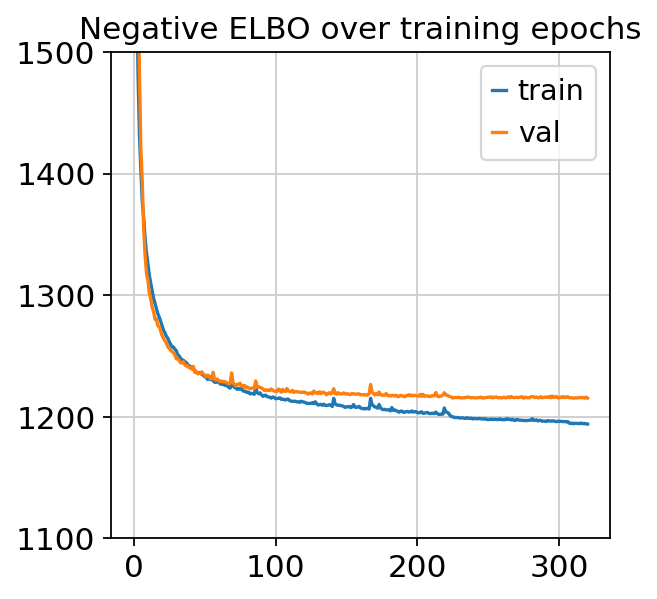

In [12]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

Again, we rely on Scanpy.

In [13]:
TOTALVI_LATENT_KEY = "X_totalVI"
PROTEIN_FG_KEY = "protein_fg_prob"

adata.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()
adata.obsm[PROTEIN_FG_KEY] = model.get_protein_foreground_probability(
    transform_batch="PBMC10k"
)

rna, protein = model.get_normalized_expression(
    transform_batch="PBMC10k", n_samples=25, return_mean=True
)

```{note}
`transform_batch` is a powerful parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch "PBMC10k" (batch categories from original adata object), but we have no protein expression in batch "PBMC5k". We'd like to take the cells of batch "PBMC5k" and make a counterfactual prediction: "What would the expression look like if my batch "PBMC5k" cells came from batch "PBMC10k"?"
```

In [14]:
protein.iloc[:5, :5]

CD3_TotalSeqB  CD4_TotalSeqB  CD8a_TotalSeqB  \
index                                                              
AAACCCAAGATTGTGA-1       9.201847     208.235474        1.050689   
AAACCCACATCGGTTA-1      27.201069     178.288391        3.560196   
AAACCCAGTACCGCGT-1      16.095518     367.685669       11.091118   
AAACCCAGTATCGAAA-1       2.829181       2.205770       34.405991   
AAACCCAGTCGTCATA-1       0.800657       0.070629       63.542938   

                    CD14_TotalSeqB  CD15_TotalSeqB  
index                                               
AAACCCAAGATTGTGA-1      828.559753      101.846344  
AAACCCACATCGGTTA-1      730.101562       99.247513  
AAACCCAGTACCGCGT-1     1281.989258      119.586426  
AAACCCAGTATCGAAA-1        0.069012      111.116081  
AAACCCAGTCGTCATA-1        0.012470      101.414154

```{important}
The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.
```

In [15]:
_, protein_means = model.get_normalized_expression(
    n_samples=25,
    transform_batch="PBMC10k",
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [16]:
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

sc.pp.neighbors(adata, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added=TOTALVI_CLUSTERS_KEY)

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is dep

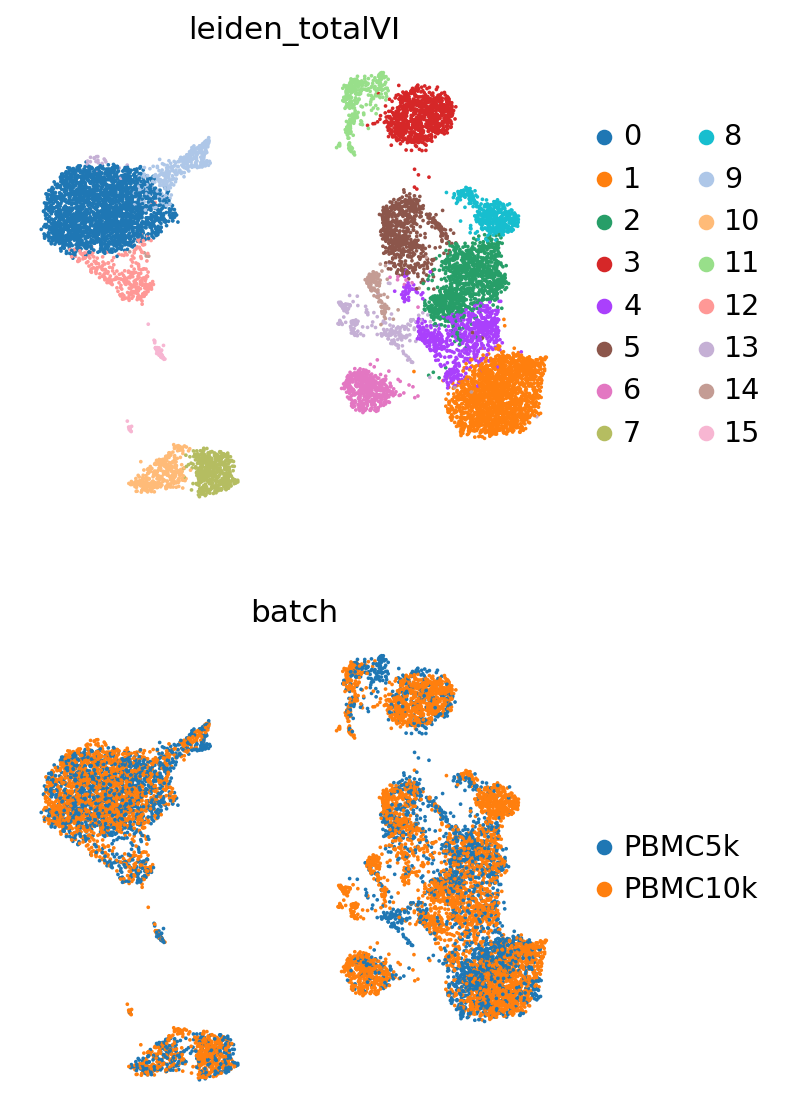

In [17]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds],
    color=[TOTALVI_CLUSTERS_KEY, "batch"],
    ncols=1,
    frameon=False,
)

In [18]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate(
    [adata.obsm["protein_expression"].values[batch == "PBMC10k"], held_out_proteins],
    axis=0,
)

# cleaner protein names
parsed_protein_names = [
    p.split("_")[0] for p in adata.obsm["protein_expression"].columns
]
for i, p in enumerate(parsed_protein_names):
    adata.obs[f"{p} imputed"] = protein_means.iloc[:, i]
    adata.obs[f"{p} observed"] = combined_protein[:, i]

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


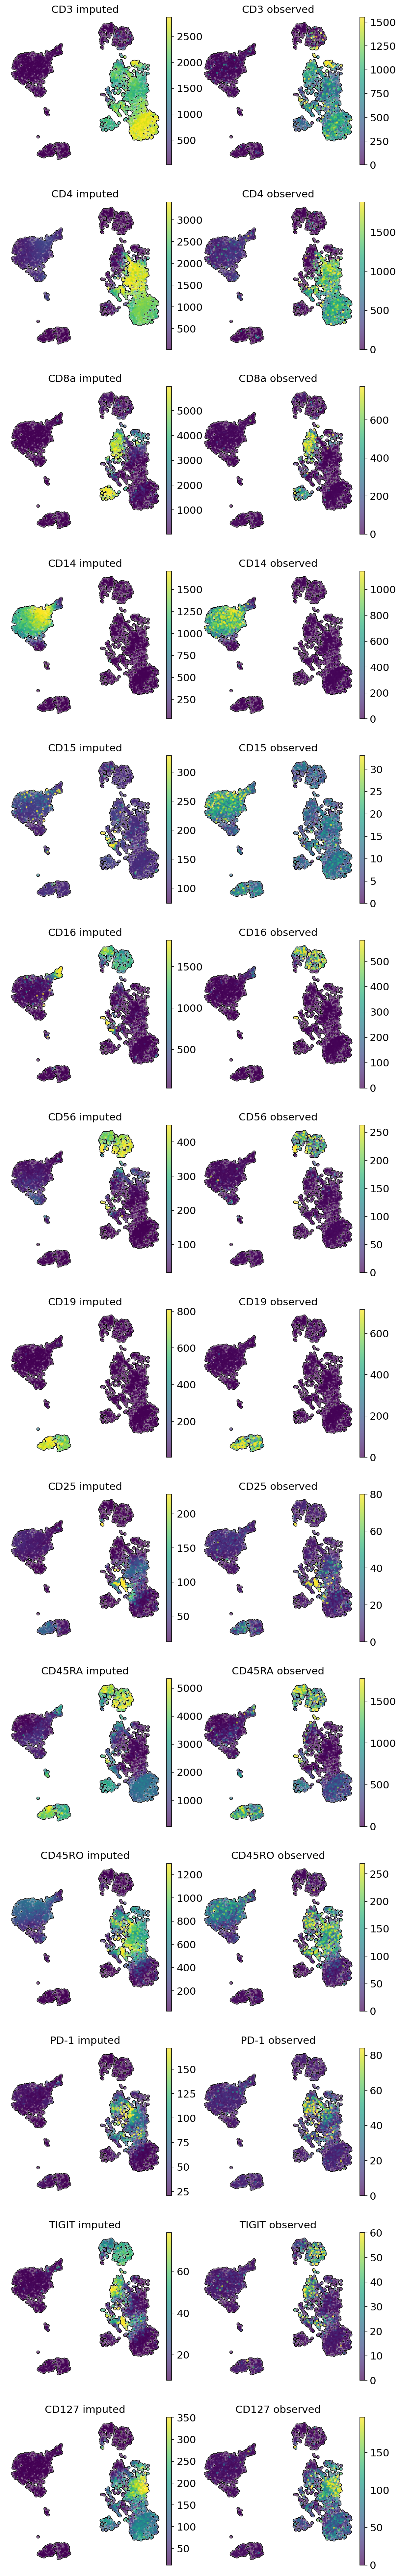

In [19]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.batch == "PBMC5k"],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1,
)

## Imputed vs denoised correlations

In [20]:
imputed_pros = protein_means[batch == "PBMC5k"]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(
        parsed_protein_names[i]
        + ": Corr="
        + str(
            np.round(
                pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3
            )
        )
    )
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.449117   CD3: Corr=0.788
1        5.105945       5.991710   CD4: Corr=0.878
2        2.833213       3.485250  CD8a: Corr=0.822
3        6.546785       7.198724  CD14: Corr=0.909
4        2.995732       4.774929  CD15: Corr=0.091

We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

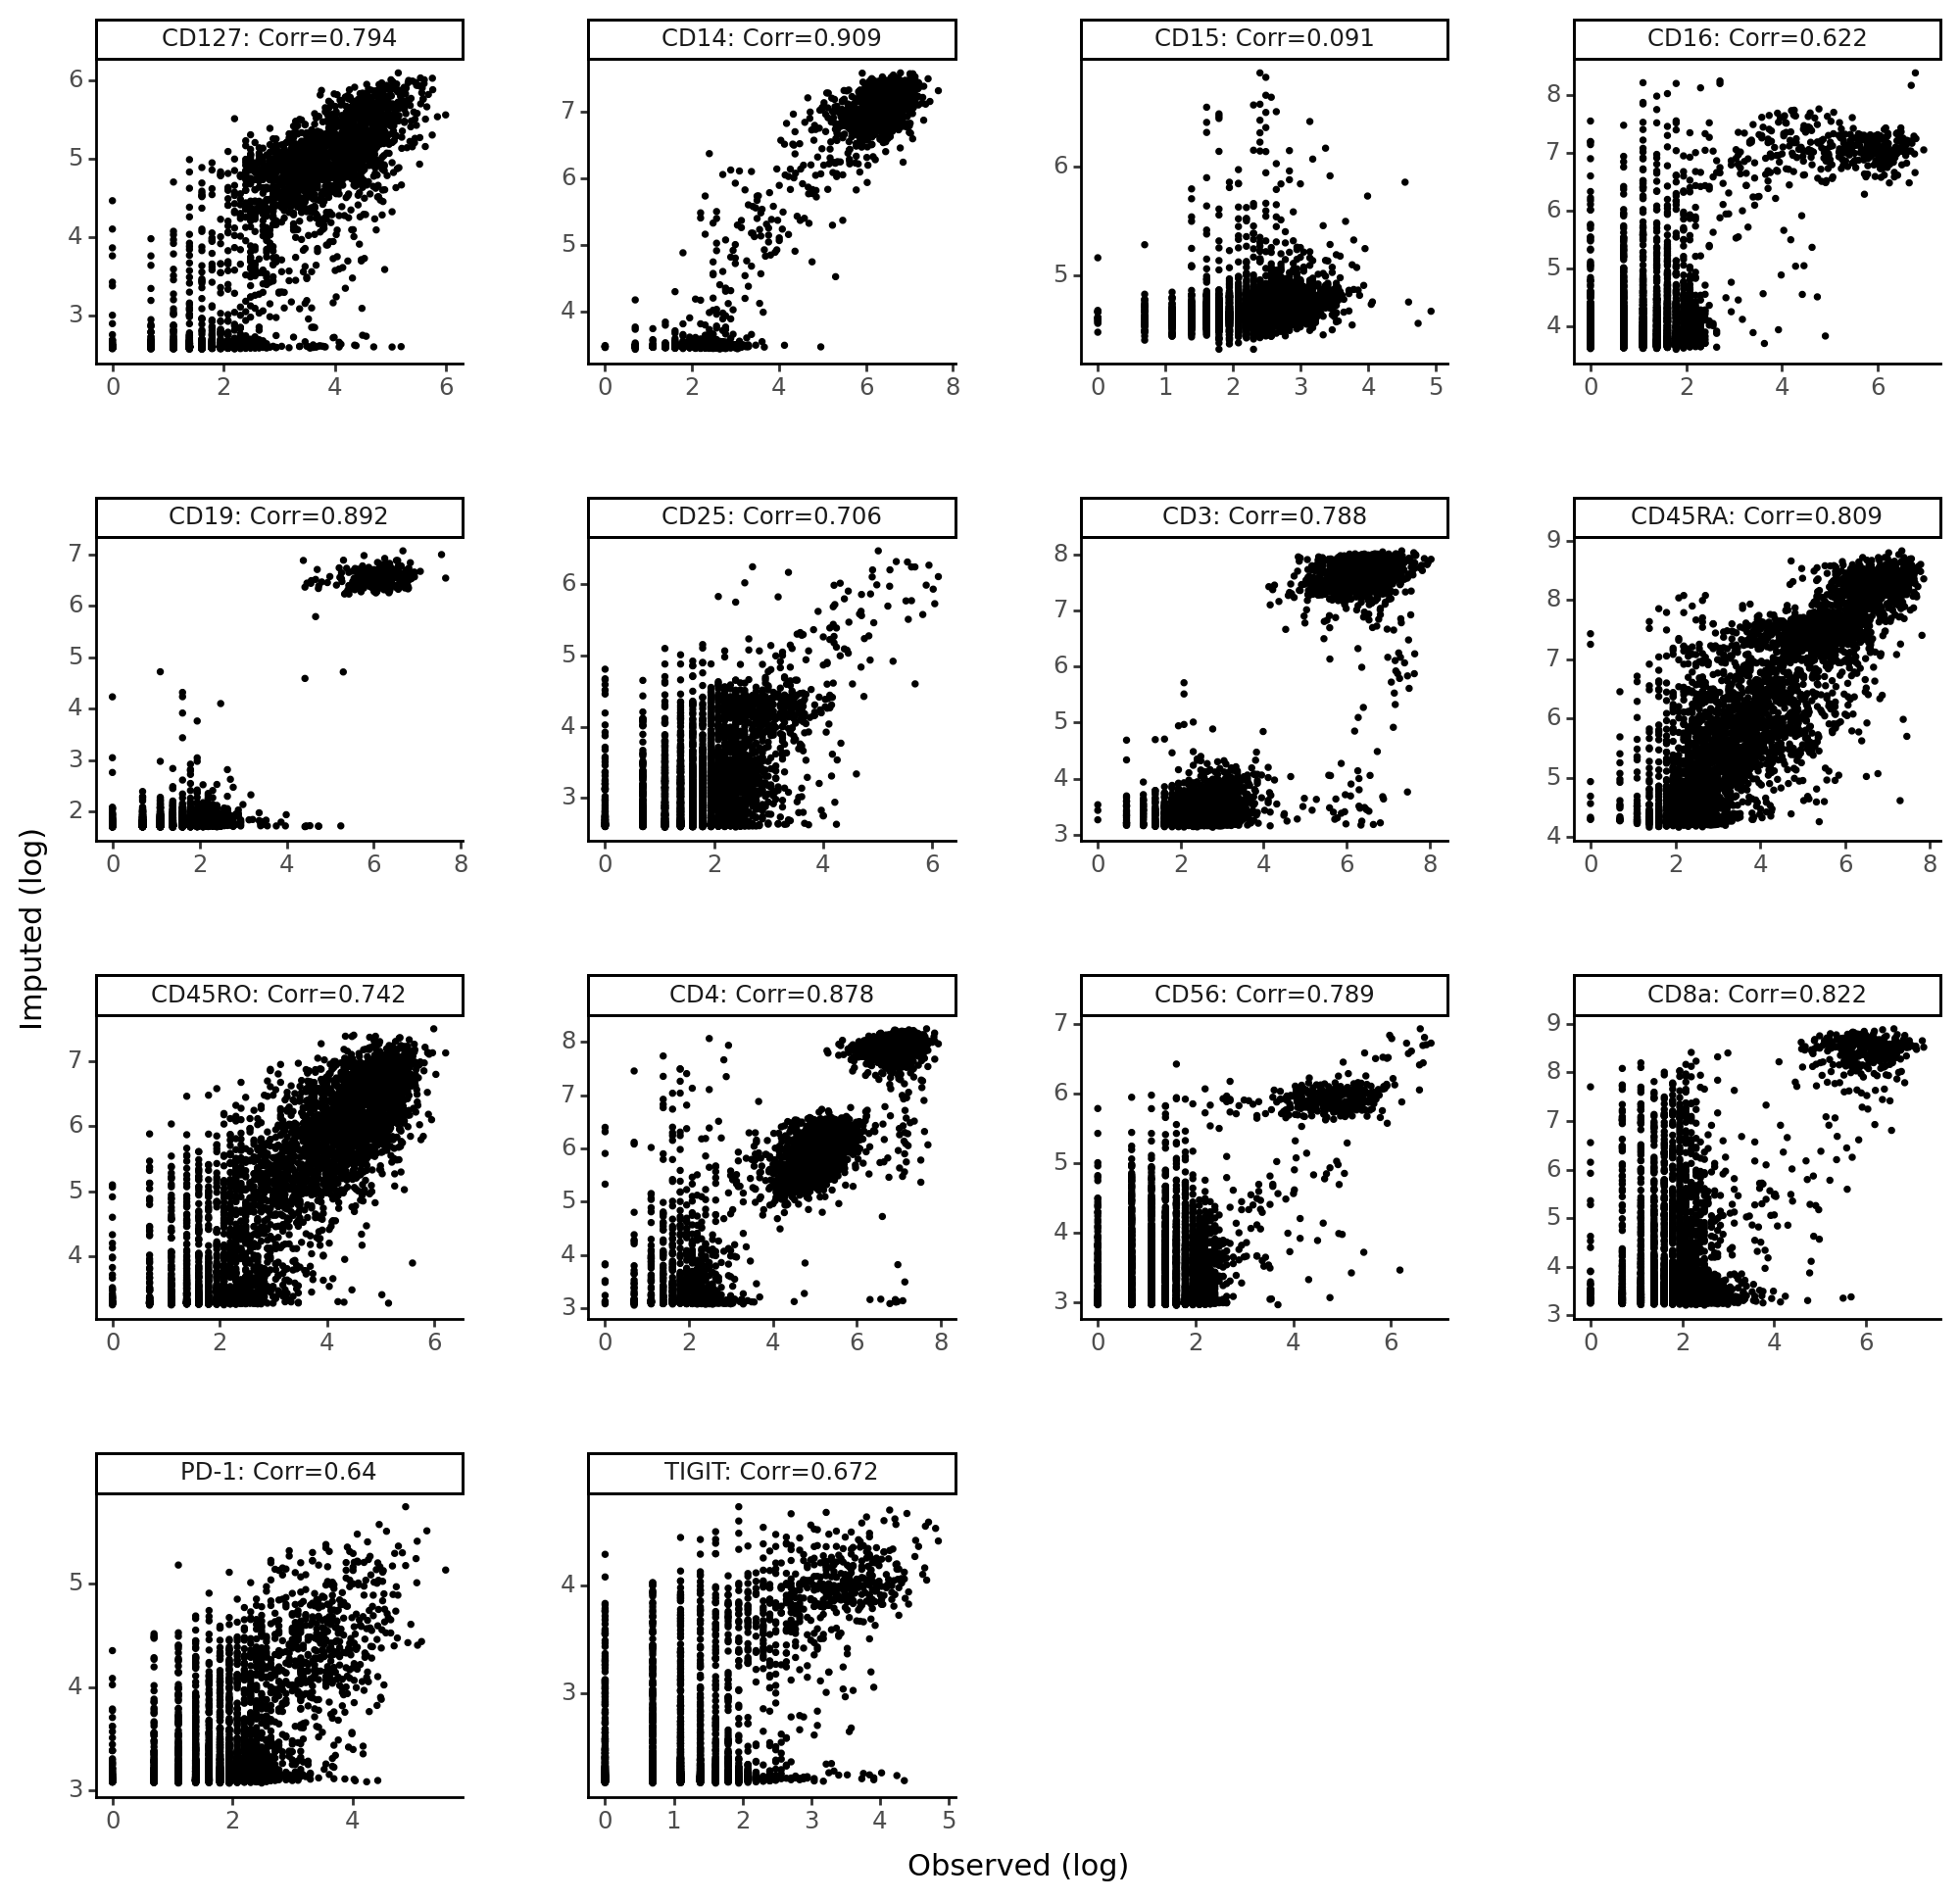

<Figure Size: (1000 x 1000)>

In [21]:
p9.theme_set(p9.theme_classic)
(
    p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
    + p9.geom_point(size=0.5)
    + p9.facet_wrap("~Protein", scales="free")
    + p9.theme(
        figure_size=(10, 10),
        panel_spacing=0.05,
    )
)

## Clean up

Uncomment the following line to remove all data files created in this tutorial:

In [22]:
# save_dir.cleanup()